In [1]:
import numpy as np
import sys
sys.path.insert(0, '../src/')
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim.lr_scheduler as lr_scheduler
from Perceptron import Perceptron
from VariableNet import VariableNet
from OneLayer import OneLayer
from TwoLayers import TwoLayers
from ThreeLayers import ThreeLayers
from FourLayers import FourLayers
from torch_utils import train_model, save_model, load_model, predictions
from utils import plot_results, cfm, filename, prediction_plots, prepareUnknown, QScanht,  plot  
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from gwpy.timeseries import TimeSeries
import seaborn as sns
torch.set_printoptions(sci_mode=False)
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500)
from urllib.error import HTTPError
from matplotlib.colors import LinearSegmentedColormap
import nds2
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

/data/gravwav/lopezm/cmb_env/miniforge3/envs/ml_course/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define functions

In [2]:
def prepareKnown(tw, ifo, run):
    path_known = '/data/gravwav/lopezm/Projects/GlitchBank/new_boostrapped/tw'+str(tw)+'/'
    data_known = 'dataset_all_'+ifo+'_bootstrap_'+run+'.npy'
    data = np.load(path_known + data_known)
    df = pd.DataFrame(data, columns=['SNR', 'Chisq', 'Mass_1', 'Mass_2', 'Spin1z', 'Spin2z', 'Class'])
    return data[:, :-1], df

In [3]:
def prepareUnknown(tw, ifo):
    path_unknown = '/data/gravwav/lopezm/Projects/GlitchBank/unknown_data/'
    data_unknown = 'features_unknown_'+ifo+'_'+str(tw)+'.csv'
    times_unknown = 'times_unknown_'+ifo+'_'+str(tw)+'.csv'
    du = pd.read_csv(path_unknown + data_unknown)
    du = du.loc[:, ~du.columns.str.match('Unnamed')]
    dt = pd.read_csv(path_unknown + times_unknown)
    dt = dt.loc[:, ~dt.columns.str.match('Unnamed')]
    dt.columns = ['Cluster ID', 'Cluster time']
    display(du)
    data = du
    gpstimes = dt
    
    data_ = data.to_numpy()
    
    return data_, data, gpstimes

In [4]:
def QScanht(start, end, ifo):
    scratch = 2
    srate = 4096.
    background = TimeSeries.fetch_open_data(ifo,
                                            start-1,
                                            end+1,
                                            sample_rate=srate)
    #print(background.times[0] - background.times[-1])
    q_scan = background.q_transform(qrange=[4,64], frange=[10, 2048],
                              tres=0.002, fres=0.5, whiten=True)
    return q_scan

def plot(q_scan, start, end, gw190521=False):
    c = 'tomato'

    fig,ax = plt.subplots(dpi=120)
    #print(start, end, tmp_time)
    ax.imshow(q_scan[100:-100], cmap='viridis')
    ax.set_yscale('log', base=2)
    ax.set_xscale('linear')
    ax.set_ylabel('Frequency (Hz)', fontsize=14)
    ax.set_xlabel('Time (s)', labelpad=0.1,  fontsize=14)
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.tick_params(axis ='both', which ='major', labelsize = 14)
    ax.axvline(start, c='tomato', label=r'$t_{min}$', linewidth=1, alpha=0.8)
    ax.axvline(end, c='orchid', label=r'$t_{max}$', linewidth=1, alpha=0.8)
    #ax.axvline(tmp_time, c='crimson', label=r'$t_{cluster}$', linewidth=1, alpha=0.8)
    cb = ax.colorbar(label='Normalized energy',clim=[0, 25.5])
    if gw190521:
        ax.axvline(1242442967.4, c='black', label=r'$GW190521$', linewidth=1, alpha=0.8)
    #ax2.legend(bbox_to_anchor=(0.5, 1.2), ncol=3)
    plt.tight_layout()
    plt.show()

In [5]:
def doubleCoincidence(data1, data2, ifo1, ifo2):
    columns=['SNR_'+ifo1, 'Chisq_'+ifo1, 'Mass_1_'+ifo1, 'Mass_2_'+ifo1, 'Spin1z_'+ifo1, 'Spin2z_'+ifo1, 'Class_'+ifo1, 'Num_triggers_'+ifo1, 'Cluster_ID'+ifo1, 'Cluster_times_'+ifo1, 'ProbInj_'+ifo1, 
             'SNR_'+ifo2, 'Chisq_'+ifo2, 'Mass_1_'+ifo2, 'Mass_2_'+ifo2, 'Spin1z_'+ifo2, 'Spin2z_'+ifo2, 'Class_'+ifo2, 'Num_triggers_'+ifo2, 'Cluster_ID'+ifo2, 'Cluster_times_'+ifo2, 'ProbInj_'+ifo2]
    print(len(columns))
    tmps = list()
    for i in range(len(data1)): 
        tmp1 = data1.iloc[i]
        tmp2 = data2.loc[(data2['Cluster time'] >= tmp1['Cluster time'] - 0.03) & (data2['Cluster time'] <= tmp1['Cluster time'] + 0.03)]

        if len(tmp2) == 1:
            tmps.append(list(tmp1.values)+ list(tmp2.values[0]))

    tmp = pd.DataFrame(tmps, columns=columns)
    return tmp

def tripleCoincidence(data1, data2, data3, ifo1, ifo2, ifo3):
    columns=['SNR_'+ifo1, 'Chisq_'+ifo1, 'Mass_1_'+ifo1, 'Mass_2_'+ifo1, 'Spin1z_'+ifo1, 'Spin2z_'+ifo1, 'Class_'+ifo1, 'Num_triggers_'+ifo1, 'Cluster_ID'+ifo1, 'Cluster_times_'+ifo1, 'ProbInj_'+ifo1, 
             'SNR_'+ifo2, 'Chisq_'+ifo2, 'Mass_1_'+ifo2, 'Mass_2_'+ifo2, 'Spin1z_'+ifo2, 'Spin2z_'+ifo2, 'Class_'+ifo2, 'Num_triggers_'+ifo2, 'Cluster_ID'+ifo2, 'Cluster_times_'+ifo2, 'ProbInj_'+ifo2,
             'SNR_'+ifo3, 'Chisq_'+ifo3, 'Mass_1_'+ifo3, 'Mass_2_'+ifo3, 'Spin1z_'+ifo3, 'Spin2z_'+ifo3, 'Class_'+ifo3, 'Num_triggers_'+ifo3, 'Cluster_ID'+ifo3, 'Cluster_times_'+ifo3, 'ProbInj_'+ifo3]
    print(len(columns))
    tmps = list()
    for i in range(len(data1)): 
        tmp1 = data1.iloc[i]
        tmp2 = data2.loc[(data2['Cluster time'] >= tmp1['Cluster time'] - 0.03) & (data2['Cluster time'] <= tmp1['Cluster time'] + 0.03)]
        tmp3 = data3.loc[(data3['Cluster time'] >= tmp1['Cluster time'] - 0.03) & (data3['Cluster time'] <= tmp1['Cluster time'] + 0.03)]

        if (len(tmp2) == 1) and (len(tmp3) == 1):
            tmps.append(list(tmp1.values)+ list(tmp2.values[0]) + list(tmp3.values[0]))

    tmp = pd.DataFrame(tmps, columns=columns)
    return tmp

In [6]:
def plot_spectrogram(tmp):
    """
    Plots a spectrogram of a given time series.

    Parameters:
        tmp (array-like): Input time series.

    Returns:
        None
    """

    # Perform q-transform
    q_scan = tmp.q_transform(qrange=[4, 64], frange=[10, 2048],
                             tres=0.002, fres=0.5, whiten=True)

    # Plot spectrogram
    fig, ax = plt.subplots(dpi=120)
    ax.imshow(q_scan, cmap='viridis', vmin=0, vmax=25.5)
    ax.set_yscale('log', base=2)
    ax.set_xscale('linear')
    ax.set_ylabel('Frequency (Hz)', fontsize=14)
    ax.set_xlabel('Time (s)', labelpad=0.1, fontsize=14)
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.tick_params(axis='both', which='major', labelsize=14)
    #cb = ax.colorbar(label='Normalized energy', clim=[0, 25.5])
    plt.show()

In [7]:
def plotSpecEvent(ifos, times):
    fig, ax = plt.subplots(1, len(ifos), dpi=120)
    for i, ifo, t in zip(np.arange(len(ifos)), ifos, times):
        strain = TimeSeries.fetch_open_data(ifo, t - 1, t + 1)
        # Perform q-transform
        q_scan = strain.q_transform(qrange=[4, 64], frange=[10, 2048],
                                 tres=0.002, fres=0.5, whiten=True)
        # Plot spectrogram
        ax[i].imshow(q_scan, cmap='viridis', vmin=0, vmax=25.5,label=ifo)
        ax[i].set_yscale('log', base=2)
        ax[i].set_xscale('linear')
        ax[0].set_ylabel('Frequency (Hz)', fontsize=14)
        if i !=0:
            ax[i].set_yticks([])
        ax[i].axvline(t, c='crimson', alpha=0.5)
        ax[i].yaxis.set_major_formatter(ScalarFormatter())

    plt.show()
    plt.tight_layout()

In [8]:
def detectedGWOSC(events, t1, df, i):
    gwosc = False
    for e in range(len(events)):

        if int(events.iloc[e]['GPS']) - int(t1) == 0: #FIXME: improve this time window

            print(i, 
                  'GW detected: ',events['commonName'][e],
                  events['catalog.shortName'][e], 
                  df.iloc[i]['Prob0_'+ifo1], df.iloc[i]['Prob0_'+ifo2])
            gwosc = True
    return gwosc

## Check data

### Preliminary

In [7]:
pH1 = pd.read_csv('../output_new/tw0.05/predictions/pred_unknown_H1.csv')
pH1 = pH1.loc[:, ~pH1.columns.str.match('Unnamed')]

pL1 = pd.read_csv('../output_new/tw0.05/predictions/pred_unknown_L1.csv')
pL1 = pL1.loc[:, ~pL1.columns.str.match('Unnamed')]

pV1 = pd.read_csv('../output_new/tw0.05/predictions/pred_unknown_V1.csv')
pV1 = pV1.loc[:, ~pV1.columns.str.match('Unnamed')]

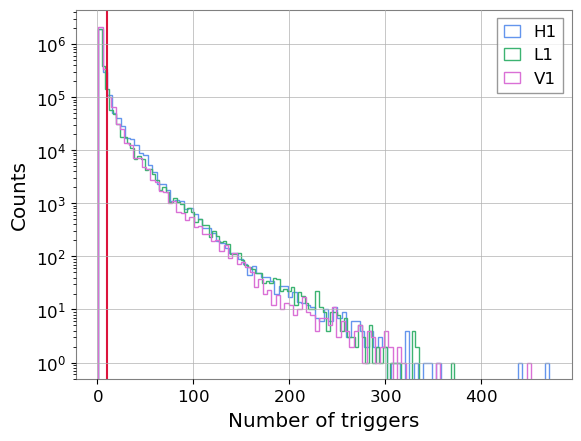

In [17]:
plt.hist(pH1['Num triggers'], bins=100, histtype='step', color='cornflowerblue', label='H1'),
plt.hist(pL1['Num triggers'], bins=100, histtype='step', color='mediumseagreen', label='L1'),
plt.hist(pV1['Num triggers'], bins=100, histtype='step', color='orchid', label='V1'),
plt.axvline(10, c='crimson')
plt.yscale('log')
plt.xlabel('Number of triggers'), plt.ylabel('Counts')
plt.legend()

In [18]:
pH1_ = pH1[(pH1['Cluster time'] > 1242442967.4 -20000) & (pH1['Cluster time'] < 1242442967.4 +20000)]
pL1_ = pL1[(pL1['Cluster time'] > 1242442967.4 -20000) & (pL1['Cluster time'] < 1242442967.4 +20000)]


display(pH1_)
display(pL1_)

SNR     Chisq     Mass_1     Mass_2    Spin1z    Spin2z  \
346167  5.504354  1.216764  42.242497   9.939208  0.937476  0.696860   
346168  4.156702  0.996336  45.039787   9.269236 -0.273304 -0.602280   
346169  4.370801  0.962821  45.105320   5.185626  0.918203  0.152546   
346170  4.094262  0.887941  62.461687   8.379415  0.340383 -0.058243   
346171  4.337716  0.571162  74.076344   8.179716  0.907492 -0.452376   
...          ...       ...        ...        ...       ...       ...   
351203  4.493062  0.820702  86.340820  15.599413  0.169537  0.448864   
351204  4.497471  1.325740  45.466864   5.293616  0.885530 -0.904661   
351205  4.384796  1.203124  47.721353   5.130854  0.839365  0.173528   
351206  4.166672  1.019102  60.245678   8.223622  0.969807 -0.464231   
351207  5.258771  1.363813  45.709526   4.600135  0.636995 -0.658684   

               Prob0         Prob1         Prob2         Prob3  Prob4  \
346167  1.082480e-10  1.052800e-10  5.226650e-30  1.936347e-10    0.0   
346168  9.999999e-01  1.060037e-08  0.000000e+00  1.124358e-07    0.0   
346169  3.243274e-04  3.456977e-14  3.705483e-34  9.996580e-01    0.0   
346170  9.721509e-01  7.881263e-13  0.000000e+00  2.784912e-02    0.0   
346171  9.433743e-01  3.368044e-24  0.000000e+00  5.660635e-02    0.0   
...              ...           ...           ...           ...    ...   
351203  9.969866e-01  7.596123e-28  0.000000e+00  2.989653e-03    0.0   
351204  4.592817e-01  4.598828e-06  1.317823e-31  2.879719e-01    0.0   
351205  6.589727e-01  3.154809e-09  9.763908e-31  3.399861e-01    0.0   
351206  4.066563e-02  5.351950e-08  0.000000e+00  9.593343e-01    0.0   
351207  5.312263e-05  1.229724e-10  8.881012e-28  6.491319e-09    0.0   

               Prob5         Prob6  Num triggers  Cluster ID  Cluster time  
346167  1.000000e+00  0.000000e+00             7     54037.0  1.242423e+09  
346168  6.075111e-09  4.718191e-23             1     54038.0  1.242423e+09  
346169  1.758542e-05  0.000000e+00             1     54039.0  1.242423e+09  
346170  1.761255e-11  6.600000e-44             3     54040.0  1.242423e+09  
346171  1.936235e-05  0.000000e+00             4     54041.0  1.242423e+09  
...              ...           ...           ...         ...           ...  
351203  2.376140e-05  0.000000e+00             1     59073.0  1.242463e+09  
351204  2.527417e-01  0.000000e+00             2     59074.0  1.242463e+09  
351205  1.041273e-03  0.000000e+00             4     59075.0  1.242463e+09  
351206  3.583359e-10  0.000000e+00             1     59076.0  1.242463e+09  
351207  9.999468e-01  0.000000e+00             1     59077.0  1.242463e+09  

[5041 rows x 16 columns]

SNR     Chisq      Mass_1      Mass_2    Spin1z    Spin2z  \
393779  5.622396  1.041820   45.487095    4.604047  0.722643  0.365065   
393780  5.741000  1.699530   45.256087    5.282516  0.529506 -0.498580   
393781  4.141871  0.843057   42.487926    9.786650  0.930597  0.647409   
393782  7.115142  1.334111  381.381559  121.817170  0.780623  0.313523   
393783  4.094980  1.330729   45.105320    5.185626  0.918203  0.152546   
...          ...       ...         ...         ...       ...       ...   
398870  4.433145  0.911486   44.128219    6.326831  0.866702  0.155271   
398871  5.420474  1.058898   86.340820   15.599413  0.169537  0.448864   
398872  5.408497  1.004455   45.464382    5.293967  0.885566 -0.904601   
398873  5.678319  0.714589   60.245678    8.223622  0.969807 -0.464231   
398874  4.659464  0.834091   45.709526    4.600135  0.636995 -0.658684   

           Prob0         Prob1         Prob2         Prob3         Prob4  \
393779  0.001476  4.811026e-07  4.598425e-26  1.467105e-05  2.982435e-37   
393780  0.155460  3.862296e-10  4.039130e-36  8.008645e-06  0.000000e+00   
393781  0.020874  7.528163e-22  1.284175e-27  9.791264e-01  1.058950e-38   
393782  0.673982  0.000000e+00  1.503164e-37  0.000000e+00  7.780454e-15   
393783  1.000000  5.223259e-12  7.893690e-21  9.156301e-13  0.000000e+00   
...          ...           ...           ...           ...           ...   
398870  0.997979  1.006534e-25  1.060241e-23  1.638180e-12  2.266520e-40   
398871  1.000000  2.488409e-16  2.198141e-32  6.059787e-21  6.573909e-14   
398872  1.000000  1.450758e-13  0.000000e+00  2.116804e-07  0.000000e+00   
398873  0.001512  2.442570e-26  0.000000e+00  9.984880e-01  0.000000e+00   
398874  0.999177  1.360112e-31  0.000000e+00  8.233998e-04  0.000000e+00   

               Prob5         Prob6  Num triggers  Cluster ID  Cluster time  
393779  4.012014e-01  5.973077e-01             1     62424.0  1.242423e+09  
393780  8.369589e-01  7.572788e-03             3     62425.0  1.242423e+09  
393781  3.854459e-26  3.399623e-14             7     62426.0  1.242423e+09  
393782  0.000000e+00  3.260182e-01            10     62427.0  1.242423e+09  
393783  2.573053e-11  2.756405e-15             1     62428.0  1.242423e+09  
...              ...           ...           ...         ...           ...  
398870  3.329493e-04  1.688237e-03             2     67515.0  1.242463e+09  
398871  7.230000e-43  6.775479e-17             1     67516.0  1.242463e+09  
398872  3.470595e-10  8.974009e-10             2     67517.0  1.242463e+09  
398873  5.367314e-19  1.400124e-07             1     67518.0  1.242463e+09  
398874  2.060592e-09  3.082405e-14             1     67519.0  1.242463e+09  

[5096 rows x 16 columns]

Index(['SNR_H1', 'Chisq_H1', 'Mass_1_H1', 'Mass_2_H1', 'Spin1z_H1',
       'Spin2z_H1', 'Prob0_H1', 'Prob1_H1', 'Prob2_H1', 'Prob3_H1', 'Prob4_H1',
       'Prob5_H1', 'Prob6_H1', 'Num triggers_H1', 'Cluster ID_H1',
       'Cluster time_H1', 'SNR_L1', 'Chisq_L1', 'Mass_1_L1', 'Mass_2_L1',
       'Spin1z_L1', 'Spin2z_L1', 'Prob0_L1', 'Prob1_L1', 'Prob2_L1',
       'Prob3_L1', 'Prob4_L1', 'Prob5_L1', 'Prob6_L1', 'Num triggers_L1',
       'Cluster ID_L1', 'Cluster time_L1'],
      dtype='object')


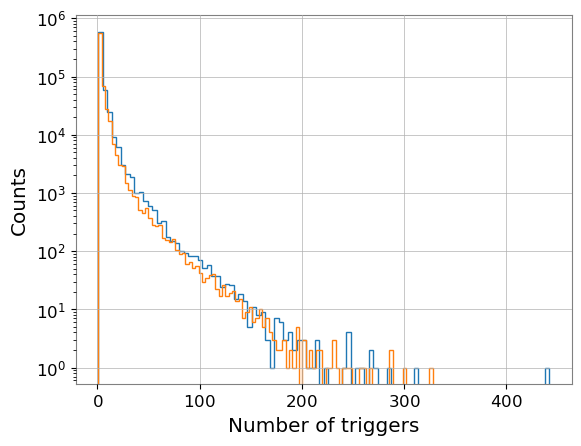

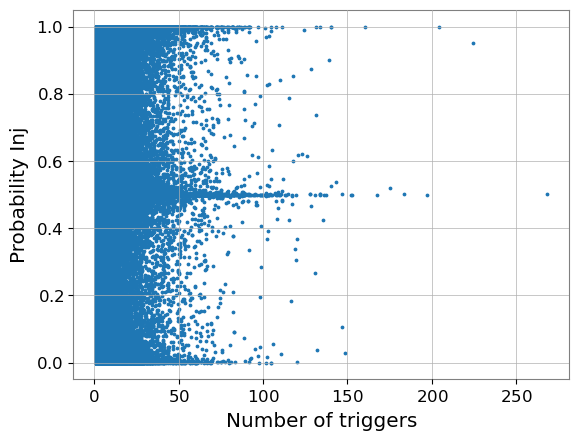

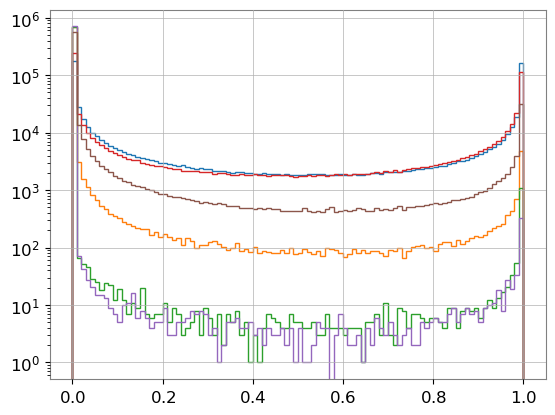

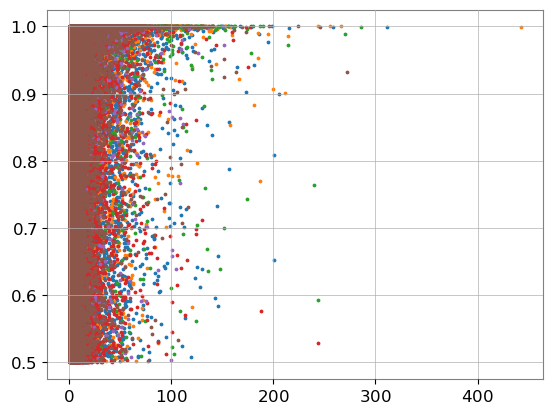

In [112]:
ifos = 'H1L1'
ifo1, ifo2 = ifos[:2], ifos[2:]

df = pd.read_csv('../output_new/tw0.05/predictions/pred_unknown_'+ifos+'.csv')
df = df.loc[:, ~df.columns.str.match('Unnamed')]
print(df.columns)
plt.hist(df['Num triggers_'+ifo1],histtype='step', bins=100)
plt.hist(df['Num triggers_'+ifo2],histtype='step', bins=100)
plt.yscale('log')
plt.xlabel('Number of triggers'), plt.ylabel('Counts')
plt.show()

plt.scatter((df['Num triggers_'+ifo1]+df['Num triggers_'+ifo2])/2,
            (df['Prob0_'+ifo1]+df['Prob0_'+ifo2])/2, s=3)
#plt.scatter(df['Num triggers_H1.1'], df['Prob0_H1.1'], s=3)

plt.xlabel('Number of triggers'), plt.ylabel('Probability Inj')
plt.show()

for i in range(6):
    plt.hist(df['Prob'+str(i)+'_'+ifo1],histtype='step', bins=100)
plt.yscale('log')
plt.show()

for i in range(6):
    tmp = df.loc[df['Prob'+str(i)+'_'+ifo1] > 0.5]
    plt.scatter(tmp['Num triggers_'+ifo1], tmp['Prob'+str(i)+'_'+ifo1], s=3)
    
df['Av num triggers'] = (df['Num triggers_'+ifo1]+df['Num triggers_'+ifo2])/2
df = df.sort_values(by='Av num triggers', ascending=False)
df = df.loc[(df['Prob0_'+ifo1]>0.9) & (df['Prob0_'+ifo2]>0.9)]
df = df.loc[(df['Av num triggers']>3)]

### Check for known GW signals

In [10]:
events = pd.read_csv('/data/gravwav/lopezm/Projects/GlitchBank/allevents.csv')

In [127]:
for ifos in ['H1L1', 'H1V1', 'L1V1']:
    ifo1, ifo2 = ifos[:2], ifos[2:]

    df = pd.read_csv('../output_new/tw0.05/predictions/pred_unknown_'+ifos+'.csv')
    df = df.loc[:, ~df.columns.str.match('Unnamed')]
    df['Av num triggers'] = (df['Num triggers_'+ifo1]+df['Num triggers_'+ifo2])/2
    df['Av prob0'] = (df['Prob0_'+ifo1]+df['Prob0_'+ifo2])/2
    df = df.sort_values(by='Av num triggers', ascending=False)
    df = df.loc[(df['Av prob0']>0.9)]
    df = df.loc[(df['Av num triggers']>3)]

    gws, catalg_gws = list(), list()
    c = 0
    times1= df['Cluster time_'+ifo1]
    for i in range(len(df)):

        #tmp = df.iloc[i]
        t1 = times1.iloc[i]

        for e in range(len(events)):

            if (int(events.iloc[e]['GPS'])) - int(t1) == 0:
                gws.append(np.asarray(df.iloc[i].values))
                catalg_gws.append(events.iloc[e].values)
                #print(i, 'GW detected: ',events['commonName'][e],events['catalog.shortName'][e], tmp['Prob0_'+ifo1], tmp['Prob0_'+ifo2])
                c = c +1
    gws = pd.DataFrame(gws, columns=df.columns)
    catalg_gws = pd.DataFrame(catalg_gws, columns=events.columns)
    discovert_2coinc = pd.merge(gws, catalg_gws, left_index=True, right_index=True)
    discovert_2coinc = discovert_2coinc.drop_duplicates(subset=['Cluster time_'+ifo1]).reset_index(drop=True)
    discovert_2coinc.to_csv('gw_known_discovert_'+ifos+'.csv')

In [119]:
gws = pd.DataFrame(gws, columns=df.columns)
catalg_gws = pd.DataFrame(catalg_gws, columns=events.columns)
discovert_2coinc = pd.merge(gws, catalg_gws, left_index=True, right_index=True)
discovert_2coinc = discovert_2coinc.drop_duplicates(subset=['Cluster time_'+ifo1]).reset_index(drop=True)


### Check results

In [11]:
events = pd.read_csv('/data/gravwav/lopezm/Projects/GlitchBank/allevents.csv')
evetns = events.loc[events['GPS']>1238166018].sort_values(by='GPS')

(45, 45, 45)

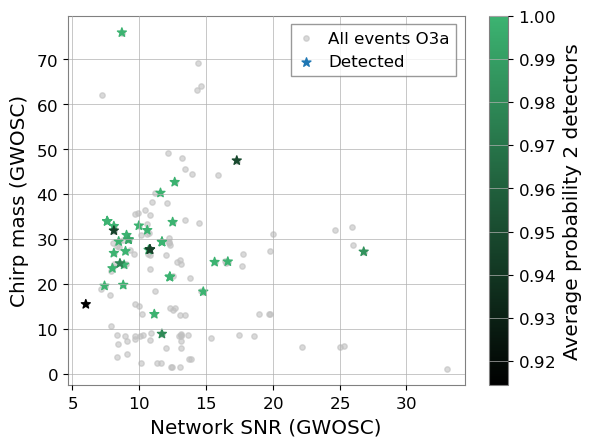

In [172]:
cmap = LinearSegmentedColormap.from_list(
        name='test', 
        colors=['black', 'mediumseagreen'])
plt.scatter(events['network_matched_filter_snr'], events['chirp_mass_source'], s=15, alpha=0.6, c='silver', label='All events O3a')
net_snrs, chirp_mass, probs = list(), list(), list()
for ifos in ['H1L1', 'L1V1', 'H1V1']:
    gw_disc = pd.read_csv('gw_known_discovert_'+ifos+'.csv')
    net_snrs.extend(gw_disc['network_matched_filter_snr'].values)
    chirp_mass.extend(gw_disc['chirp_mass_source'].values)
    probs.extend((gw_disc['Prob0_'+ifos[:2]].values+gw_disc['Prob0_'+ifos[2:]].values)/2)
plt.scatter(net_snrs,chirp_mass, s=45, marker='*',c=probs, cmap=cmap, label='Detected')
plt.colorbar(label='Average probability 2 detectors')
plt.xlabel('Network SNR (GWOSC)')
plt.ylabel('Chirp mass (GWOSC)')
plt.legend()
len(net_snrs), len(chirp_mass), len(probs)

In [38]:
df.columns

Index(['SNR_L1', 'Chisq_L1', 'Mass_1_L1', 'Mass_2_L1', 'Spin1z_L1',
       'Spin2z_L1', 'Prob0_L1', 'Prob1_L1', 'Prob2_L1', 'Prob3_L1', 'Prob4_L1',
       'Prob5_L1', 'Prob6_L1', 'Num triggers_L1', 'Cluster ID_L1',
       'Cluster time_L1', 'SNR_V1', 'Chisq_V1', 'Mass_1_V1', 'Mass_2_V1',
       'Spin1z_V1', 'Spin2z_V1', 'Prob0_V1', 'Prob1_V1', 'Prob2_V1',
       'Prob3_V1', 'Prob4_V1', 'Prob5_V1', 'Num triggers_V1', 'Cluster ID_V1',
       'Cluster time_V1', 'Av num triggers', 'Av prob0'],
      dtype='object')

In [42]:
ifos = 'L1V1'
ifo1, ifo2 = ifos[:2], ifos[2:]
df = pd.read_csv('../output_new/tw0.05/predictions/pred_unknown_'+ifos+'.csv')
df = df.loc[:, ~df.columns.str.match('Unnamed')]
df['Av num triggers'] = (df['Num triggers_'+ifo1]+df['Num triggers_'+ifo2])/2
df['Av prob0'] = (df['Prob0_'+ifo1]+df['Prob0_'+ifo2])/2
df = df.sort_values(by=['Num triggers_'+ifo1, 'Num triggers_'+ifo2], ascending=False)
df = df.loc[(df['Av prob0']>0.9)]
df = df.loc[(df['Num triggers_'+ifo1] >= 3) & (df['Num triggers_'+ifo2] > 3)]
m = 5
#df = df.loc[(df['Mass_1_'+ifo2] >= df['Mass_1_'+ifo1] - m) & (df['Mass_1_'+ifo2] <= df['Mass_1_'+ifo1] + m)]
#display(df)

for i in range(20):
    tmp = df.iloc[i]
    t1 = tmp['Cluster time_'+ifo1]
    m1 = tmp['Mass_1_'+ifo1]
    m2 = tmp['Mass_1_'+ifo2]
    if m1 - m
    gwosc = detectedGWOSC(events, t1)

    #if gwosc is False:
    print('SNR',df.iloc[i]['SNR_'+ifo1], df.iloc[i]['SNR_'+ifo2])
    print('mass 1',  df.iloc[i]['Mass_1_'+ifo1], df.iloc[i]['Mass_1_'+ifo2])
    print('num triggers',  df.iloc[i]['Num triggers_'+ifo1], df.iloc[i]['Num triggers_'+ifo2])
    print('cluster time',  df.iloc[i]['Cluster time_'+ifo1], df.iloc[i]['Cluster time_'+ifo2])


    #plotSpecEvent([ifo1, ifo2],
    #              [df.iloc[i]['Cluster time_'+ifo1], df.iloc[i]['Cluster time_'+ifo2]])
    print(' ')


0 GW detected:  GW190513_205428 GWTC-2 1.0 1.0
0 GW detected:  GW190513_205428 GWTC-2.1-confident 1.0 1.0
SNR 7.5910430386679115 4.323596776899007
mass 1 56.323583311431406 53.40591663844443
num triggers 241.0 125.0
cluster time 1241816086.7503679 1241816086.7300675
 
SNR 11.677804730823468 4.638624862054795
mass 1 56.68986694021594 51.56480720122218
num triggers 230.0 30.0
cluster time 1264339642.090029 1264339642.062751
 
SNR 10.992552005913025 4.072010331286234
mass 1 59.79234478976287 66.09311549296821
num triggers 209.0 8.0
cluster time 1269271470.0705845 1269271470.0875006
 
SNR 8.928831526566967 4.132876663224335
mass 1 57.9538394116251 49.68444087282596
num triggers 202.0 20.0
cluster time 1267699738.476366 1267699738.4641445
 
SNR 14.781951310083524 4.05215808910843
mass 1 78.70294198995398 50.060765634473285
num triggers 200.0 5.0
cluster time 1250764062.452807 1250764062.4576447
 
SNR 13.571211535422387 4.375809169815058
mass 1 60.142983733130244 64.33763946889455
num trigge

In [18]:
df.columns

Index(['SNR_L1', 'Chisq_L1', 'Mass_1_L1', 'Mass_2_L1', 'Spin1z_L1',
       'Spin2z_L1', 'Prob0_L1', 'Prob1_L1', 'Prob2_L1', 'Prob3_L1', 'Prob4_L1',
       'Prob5_L1', 'Prob6_L1', 'Num triggers_L1', 'Cluster ID_L1',
       'Cluster time_L1', 'SNR_V1', 'Chisq_V1', 'Mass_1_V1', 'Mass_2_V1',
       'Spin1z_V1', 'Spin2z_V1', 'Prob0_V1', 'Prob1_V1', 'Prob2_V1',
       'Prob3_V1', 'Prob4_V1', 'Prob5_V1', 'Num triggers_V1', 'Cluster ID_V1',
       'Cluster time_V1', 'Av num triggers', 'Av prob0'],
      dtype='object')

ValueError: Input signal contains non-numerical values

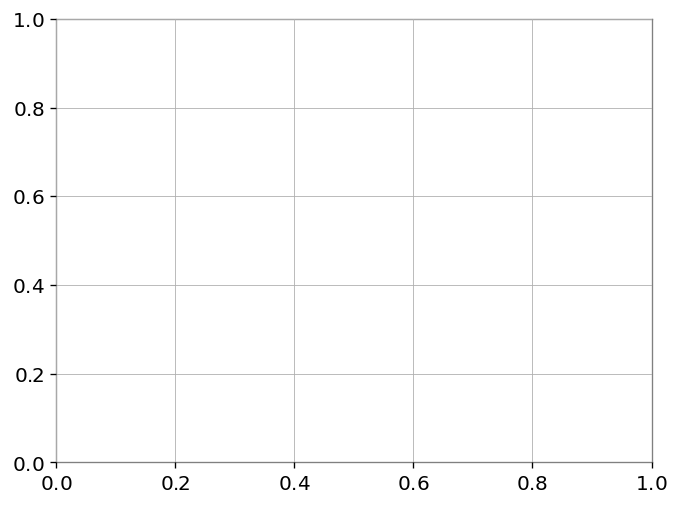

In [163]:
t1 = 1262909226.0602279
fig, ax = plt.subplots(dpi=120)
strain = TimeSeries.fetch_open_data('V1', t1 - 1, t1 + 1)
# Perform q-transform
q_scan = strain.q_transform(qrange=[4, 64], frange=[10, 2048],
                         tres=0.002, fres=0.5, whiten=True)
# Plot spectrogram
ax.imshow(q_scan, cmap='viridis', vmin=0, vmax=25.5)
ax.set_yscale('log', base=2)
ax.set_xscale('linear')
ax.set_ylabel('Frequency (Hz)', fontsize=14)
ax.axvline(t1, c='crimson', alpha=0.5)
ax.yaxis.set_major_formatter(ScalarFormatter())

plt.show()

In [150]:
ifos = 'H1L1V1'
ifo1, ifo2, ifo3 = 'H1', 'L1', 'V1'
df = pd.read_csv('../output_new/tw0.05/predictions/pred_unknown_'+ifos+'.csv')
df = df.loc[:, ~df.columns.str.match('Unnamed')]
df['Av num triggers'] = (df['Num triggers_'+ifo1]+df['Num triggers_'+ifo2]+df['Num triggers_'+ifo3])/3
df['Av prob0'] = (df['Prob0_'+ifo1]+df['Prob0_'+ifo2]+df['Prob0_'+ifo3])/3
df = df.sort_values(by=['Num triggers_'+ifo1, 'Num triggers_'+ifo2, 'Num triggers_'+ifo3], ascending=False)
df = df.loc[(df['Av prob0']>0.9)]
df = df.loc[(df['Av num triggers']>3)]
df.columns

ifos = ['H1', 'L1', 'V1']

for i in range(10):

    print('SNR', df.iloc[i]['SNR_H1'], df.iloc[i]['SNR_L1'], df.iloc[i]['SNR_V1'])
    print('mass 1', df.iloc[i]['Mass_1_H1'], df.iloc[i]['Mass_1_L1'], df.iloc[i]['Mass_1_V1'])
    print('num triggers', df.iloc[i]['Num triggers_H1'], df.iloc[i]['Num triggers_L1'], df.iloc[i]['Num triggers_V1'])
    print('cluster time', df.iloc[i]['Cluster time_H1'], df.iloc[i]['Cluster time_L1'], df.iloc[i]['Cluster time_V1'])
    t1 = df.iloc[i]['Cluster time_H1']
    for e in range(len(events)):

        if int(events.iloc[e]['GPS']) - int(t1) == 0:
            print(i, 'GW detected: ',events['commonName'][e],
                  events['catalog.shortName'][e], df.iloc[i]['Prob0_'+ifo1], df.iloc[i]['Prob0_'+ifo2])
    print(' ')
    #plotSpecEvent(['H1', 'L1', 'V1'],
    #              [df.iloc[i]['Cluster time_H1'], df.iloc[i]['Cluster time_L1'], df.iloc[i]['Cluster time_V1']])

SNR 15.571414117863377 4.097945435132858 4.0989279279951365
mass 1 60.66570449681966 52.40471406630726 61.282945285305615
num triggers 311.0 10.0 6.0
cluster time 1241768799.075712 1241768799.0564704 1241768799.0513985
 
SNR 8.073710136004383 7.5910430386679115 4.323596776899007
mass 1 53.01694516004533 56.323583311431406 53.40591663844443
num triggers 168.0 241.0 125.0
cluster time 1241816086.7506106 1241816086.7503679 1241816086.7300675
1 GW detected:  GW190513_205428 GWTC-2 1.0 1.0
1 GW detected:  GW190513_205428 GWTC-2.1-confident 1.0 1.0
 
SNR 17.503705243832925 4.070208882939108 4.556173868650822
mass 1 63.05403419571726 57.35486570232071 58.007998456188155
num triggers 133.0 6.0 20.0
cluster time 1268300078.084744 1268300078.0940044 1268300078.0859766
 
SNR 15.79702630183534 4.1489454411645665 4.3422398587305375
mass 1 61.68717274978837 42.60427671201658 58.95001942074379
num triggers 130.0 3.0 27.0
cluster time 1247588241.0926926 1247588241.0641146 1247588241.1078465
 
SNR 12.4

### Catalog O3 in our search

In [9]:
events = pd.read_csv('/data/gravwav/lopezm/Projects/GlitchBank/allevents.csv')
events = events.loc[events['GPS']>1238166018].sort_values(by='GPS')

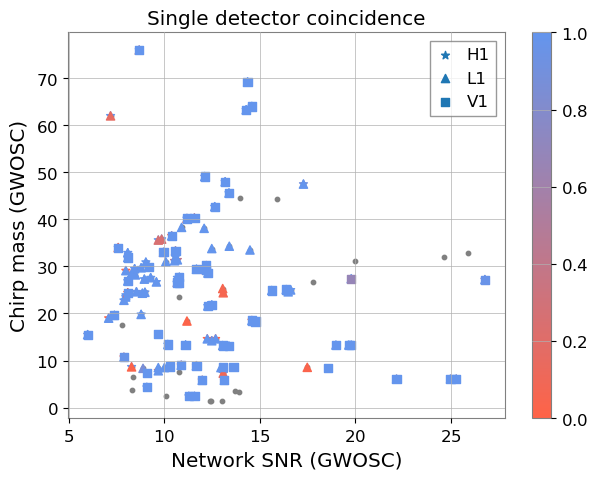

In [86]:

fig = plt.figure(dpi=100)
plt.scatter(events['network_matched_filter_snr'], events['chirp_mass_source'],
            s=10, c='grey')

for ifos, m in zip(['H1', 'L1', 'V1'], ['*', '^', 's']):
    cmap = LinearSegmentedColormap.from_list(
        name='test', 
        colors=['tomato', 'cornflowerblue'])
    #ifo1, ifo2 = ifos[:2], ifos[2:]
    ifo1 = ifos
    df = pd.read_csv('../output_new/tw0.05/predictions/pred_unknown_'+ifos+'.csv')

    names, net_snrs, chirp_mass, probs = list(), list(), list(), list()
    for t in range(len(events)):

        time = events.iloc[t]['GPS']

        tmp = df.loc[(df['Cluster time'] >= time - 1) & (df['Cluster time'] <= time + 1)]
        names.append(events.iloc[t]['commonName'])
        net_snrs.append(events.iloc[t]['network_matched_filter_snr'])
        chirp_mass.append(events.iloc[t]['chirp_mass_source'])
        if len(tmp) == 0 :
            probs.append(0)
        else:
            probs.append((tmp['Prob0'].values[0] + tmp['Prob0'].values[0])/2)
    gw_detection = pd.DataFrame({'Name': names, 'SNR':net_snrs,
                             'Chirp mass':chirp_mass, 'Probability':probs})
    gw_detection_ = gw_detection.loc[(gw_detection['Probability'] > 0.01)]
  
    plt.scatter(gw_detection_['SNR'], gw_detection_['Chirp mass'],
                c=gw_detection_['Probability'],
                vmin=0, vmax=1, s=35, marker=m, cmap=cmap, label=ifos)
plt.colorbar()
plt.xlabel('Network SNR (GWOSC)')
plt.ylabel('Chirp mass (GWOSC)')
plt.tight_layout()
plt.title('Single detector coincidence')
plt.legend()

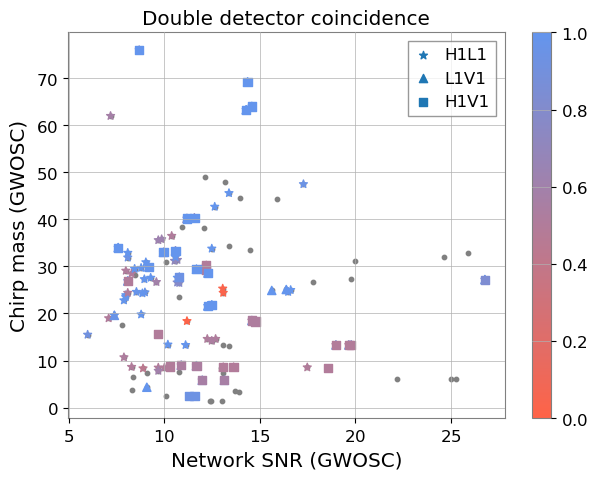

In [87]:

fig = plt.figure(dpi=100)
plt.scatter(events['network_matched_filter_snr'], events['chirp_mass_source'],
            s=10, c='grey')
for ifos, m in zip(['H1L1', 'L1V1', 'H1V1'], ['*', '^', 's']):
    cmap = LinearSegmentedColormap.from_list(
        name='test', 
        colors=['tomato', 'cornflowerblue'])
    ifo1, ifo2 = ifos[:2], ifos[2:]
    df = pd.read_csv('../output_new/tw0.05/predictions/pred_unknown_'+ifos+'.csv')

    names, net_snrs, chirp_mass, probs = list(), list(), list(), list()
    for t in range(len(events)):

        time = events.iloc[t]['GPS']

        tmp = df.loc[(df['Cluster time_'+ifo1] >= time - 1) & (df['Cluster time_'+ifo1] <= time + 1)]
        names.append(events.iloc[t]['commonName'])
        net_snrs.append(events.iloc[t]['network_matched_filter_snr'])
        chirp_mass.append(events.iloc[t]['chirp_mass_source'])
        if len(tmp) == 0 :
            probs.append(0)
        else:
            probs.append((tmp['Prob0_'+ifos[:2]].values[0] + tmp['Prob0_'+ifos[2:]].values[0])/2)
    gw_detection = pd.DataFrame({'Name': names, 'SNR':net_snrs,
                             'Chirp mass':chirp_mass, 'Probability':probs})
    gw_detection_ = gw_detection.loc[(gw_detection['Probability'] > 0.01)]
  
    plt.scatter(gw_detection_['SNR'], gw_detection_['Chirp mass'],
                c=gw_detection_['Probability'], vmin=0, vmax=1, s=35, marker=m,
                cmap=cmap, label=ifos)
plt.colorbar()
plt.xlabel('Network SNR (GWOSC)')
plt.ylabel('Chirp mass (GWOSC)')
plt.tight_layout()
plt.title('Double detector coincidence')
plt.legend()

In [14]:
events_marginal = events.loc[events['catalog.shortName'] =='O3_IMBH_marginal']
events_marginal

id     commonName  version catalog.shortName           GPS  \
14  190924_232654-v1  190924_232654        1  O3_IMBH_marginal 1253402833.00   
16  191223_014159-v1  191223_014159        1  O3_IMBH_marginal 1261100537.60   
17  191225_215715-v1  191225_215715        1  O3_IMBH_marginal 1261346253.90   
18  200114_020818-v1  200114_020818        1  O3_IMBH_marginal 1263002916.20   
21  200214_224526-v1  200214_224526        1  O3_IMBH_marginal 1265755544.50   

             reference  \
14  /O3_IMBH_marginal/   
16  /O3_IMBH_marginal/   
17  /O3_IMBH_marginal/   
18  /O3_IMBH_marginal/   
21  /O3_IMBH_marginal/   

                                                                           jsonurl  \
14  https://www.gw-openscience.org/eventapi/json/O3_IMBH_marginal/190924_232654/v1   
16  https://www.gw-openscience.org/eventapi/json/O3_IMBH_marginal/191223_014159/v1   
17  https://www.gw-openscience.org/eventapi/json/O3_IMBH_marginal/191225_215715/v1   
18  https://www.gw-openscience.org/eventapi/json/O3_IMBH_marginal/200114_020818/v1   
21  https://www.gw-openscience.org/eventapi/json/O3_IMBH_marginal/200214_224526/v1   

    mass_1_source  mass_1_source_lower  mass_1_source_upper  ...  \
14            nan                  nan                  nan  ...   
16            nan                  nan                  nan  ...   
17            nan                  nan                  nan  ...   
18            nan                  nan                  nan  ...   
21            nan                  nan                  nan  ...   

    redshift_upper  far  far_lower  far_upper  p_astro  p_astro_lower  \
14             nan 0.40        nan        nan      nan            nan   
16             nan 0.46        nan        nan      nan            nan   
17             nan 0.47        nan        nan      nan            nan   
18             nan 0.06        nan        nan      nan            nan   
21             nan 0.13        nan        nan      nan            nan   

    p_astro_upper  final_mass_source  final_mass_source_lower  \
14            nan                nan                      nan   
16            nan                nan                      nan   
17            nan                nan                      nan   
18            nan                nan                      nan   
21            nan                nan                      nan   

    final_mass_source_upper  
14                      nan  
16                      nan  
17                      nan  
18                      nan  
21                      nan  

[5 rows x 43 columns]

Name   SNR  Num templates  Probability           GPS   Cluster GPS
4  200214_224526 13.10              2         0.81 1265755544.50 1265755543.89

Name   SNR  Num templates  Probability           GPS   Cluster GPS
0  190924_232654 13.27             54         0.45 1253402833.00 1253402832.93
4  200214_224526 13.10              6         0.03 1265755544.50 1265755544.72

Name   SNR  Num templates  Probability           GPS   Cluster GPS
0  190924_232654 13.27             36         1.00 1253402833.00 1253402832.97
4  200214_224526 13.10              6         1.00 1265755544.50 1265755544.80

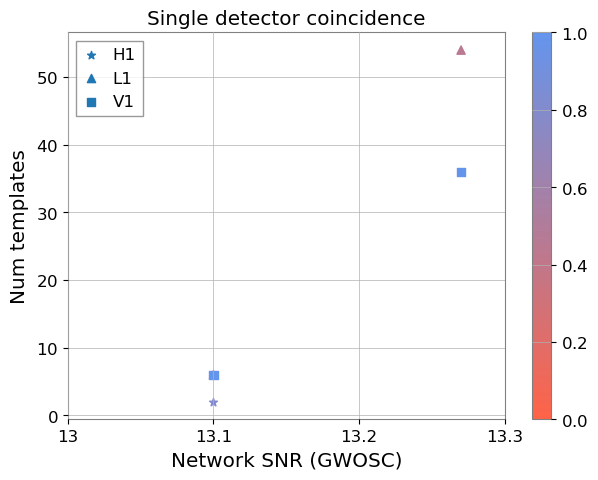

In [48]:

fig = plt.figure(dpi=100)
plt.scatter(events_marginal['network_matched_filter_snr'],
            events_marginal['chirp_mass_source'],
            s=10, c='grey')

for ifos, m in zip(['H1', 'L1', 'V1'], ['*', '^', 's']):
    cmap = LinearSegmentedColormap.from_list(
        name='test', 
        colors=['tomato', 'cornflowerblue'])
    ifo1 = ifos
    df = pd.read_csv('../output_new/tw0.05/predictions/pred_unknown_'+ifos+'.csv')

    names, net_snrs, num_templates, probs, gps, gps_ = list(), list(), list(), list(), list(), list()
    for t in range(len(events_marginal)):

        time = events_marginal.iloc[t]['GPS']

        tmp = df.loc[(df['Cluster time'] >= time - 1) & (df['Cluster time'] <= time + 1)]
        names.append(events_marginal.iloc[t]['commonName'])
        net_snrs.append(events_marginal.iloc[t]['network_matched_filter_snr'])
        gps.append(events_marginal.iloc[t]['GPS'])

        if len(tmp) == 0 :
            probs.append(0)
            num_templates.append(0)
            gps_.append(0)
        else:
            gps_.append(tmp['Cluster time'].values[0])

            num_templates.append(tmp['Num triggers'].values[0])
            probs.append((tmp['Prob0'].values[0] + tmp['Prob0'].values[0])/2)
    gw_detection = pd.DataFrame({'Name': names, 'SNR':net_snrs,
                             'Num templates':num_templates, 'Probability':probs,
                                 'GPS':gps, 'Cluster GPS':gps_})
    gw_detection_ = gw_detection.loc[(gw_detection['Probability'] > 0.01)]
    
    plt.scatter(gw_detection_['SNR'], gw_detection_['Num templates'],
                c=gw_detection_['Probability'],
                vmin=0, vmax=1, s=35, marker=m, cmap=cmap,label=ifos)
    display(gw_detection_)
plt.colorbar()
plt.xlabel('Network SNR (GWOSC)')
plt.ylabel('Num templates')
plt.xticks([13, 13.1, 13.2, 13.3], [13, 13.1, 13.2, 13.3])
plt.tight_layout()
plt.title('Single detector coincidence')
plt.legend()

### Glitches

In [90]:
!ls ../output_new/tw0.05/

95.42Acc_L1_ThreeLayers350_350_350Units_ReLU_CrossEntropyLoss_Adam_0.001lr_3505epochs_10batches
95.42Acc_L1_ThreeLayers350_350_350Units_ReLU_CrossEntropyLoss_Adam_0.001lr_3505epochs_10batchesAcc_L1_ThreeLayers350_350_350Units_ReLU_CrossEntropyLoss_Adam_0.001lr_3505epochs_10batchessummary.npy
95.42Acc_L1_ThreeLayers350_350_350Units_ReLU_CrossEntropyLoss_Adam_0.001lr_3505epochs_10batches.png
95.42Acc_L1_ThreeLayers350_350_350Units_ReLU_CrossEntropyLoss_Adam_0.001lr_3505epochs_10batches.pth
98.72Acc_H1_ThreeLayers350_350_350Units_ReLU_CrossEntropyLoss_Adam_0.001lr_2771epochs_10batches
98.72Acc_H1_ThreeLayers350_350_350Units_ReLU_CrossEntropyLoss_Adam_0.001lr_2771epochs_10batchesAcc_H1_ThreeLayers350_350_350Units_ReLU_CrossEntropyLoss_Adam_0.001lr_2771epochs_10batchessummary.npy
98.72Acc_H1_ThreeLayers350_350_350Units_ReLU_CrossEntropyLoss_Adam_0.001lr_2771epochs_10batches.png
98.72Acc_H1_ThreeLayers350_350_350Units_ReLU_CrossEntropyLoss_Adam_0.001lr_2771epochs_10batches.pth
99.05Acc_V1_Th

#### Double coincidence

705426
183272
10212
8530
8431
8350
279


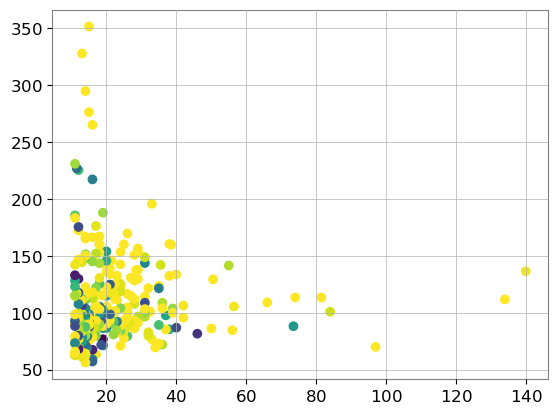

In [6]:
ifos = 'H1L1'
ifo1, ifo2 = ifos[:2], ifos[2:]

df = pd.read_csv('../output_new/tw0.05/predictions/pred_unknown_'+ifos+'.csv')
df = df.loc[:, ~df.columns.str.match('Unnamed')]
print(len(df))
df = df.loc[(df['Prob0_'+ifo1] > 0.9) & (df['Prob0_'+ifo2] > 0.9)]
print(len(df))
df = df.loc[(df['Num triggers_'+ifo1] > 10) & (df['Num triggers_'+ifo2] > 10)]
print(len(df))
df = df.loc[(df['Mass_1_'+ifo1] - 3 < df['Mass_1_'+ifo2]) & (df['Mass_1_'+ifo1] + 3 > df['Mass_1_'+ifo2])]
print(len(df))
df = df.loc[(df['Mass_2_'+ifo1] - 3 < df['Mass_2_'+ifo2]) & (df['Mass_2_'+ifo1] + 3 > df['Mass_2_'+ifo2])]
print(len(df))
df = df.loc[(df['SNR_'+ifo1] - 3 < df['SNR_'+ifo2]) & (df['SNR_'+ifo1] + 3 > df['SNR_'+ifo2])]
print(len(df))
df = df.loc[(df['SNR_'+ifo1] > 5) & (df['SNR_'+ifo2] > 5)]
print(len(df))
df = df.sort_values(by=['Num triggers_'+ifo1, 'Num triggers_'+ifo2], ascending=False)

chirpmass = (df['Mass_1_'+ifo1]*df['Mass_2_'+ifo1]**(3/5)/(df['Mass_1_'+ifo1]+df['Mass_2_'+ifo1])**(1/5))
plt.scatter((df['Num triggers_'+ifo1]+df['Num triggers_'+ifo2])/2, chirpmass, c=(df['Prob0_'+ifo1]+df['Prob0_'+ifo2])/2)

In [7]:
!ls /data/gravwav/lopezm/Projects/GlitchBank/data-visualization-and-optimisation/Results/

test_H1L1.csv


In [23]:
df.to_pickle('/data/gravwav/lopezm/Projects/GlitchBank/data-visualization-and-optimisation/Results/test_H1L1.csv')

In [22]:
events = pd.read_csv('/data/gravwav/lopezm/Projects/GlitchBank/allevents.csv')
events = events.loc[events['GPS']>1238166018].sort_values(by='GPS')
pars = list()
for t in range(100):
    t_star = df.iloc[t]['Cluster time_'+ifo1]
    try:
        gwosc = detectedGWOSC(events, t_star, df, t)
    except KeyError as e:
        print(e)
        gwosc = False
    if gwosc:
        print('GWOSC detected')
        print(t, t_star,
              df.iloc[t]['Prob0_'+ifo1], df.iloc[t]['Prob0_'+ifo2],
              df.iloc[t]['Num triggers_'+ifo1], df.iloc[t]['Num triggers_'+ifo2], 
              df.iloc[t]['SNR_'+ifo1], df.iloc[t]['SNR_'+ifo2],
              df.iloc[t]['Mass_1_'+ifo1], df.iloc[t]['Mass_1_'+ifo2], df.iloc[t]['Mass_2_'+ifo1], df.iloc[t]['Mass_2_'+ifo2])

    else:
        pass
    """
        print(' New! ')
        
        pars.append([t_star,
              df.iloc[t]['Prob0_'+ifo1], df.iloc[t]['Prob0_'+ifo2],
              df.iloc[t]['Num triggers_'+ifo1], df.iloc[t]['Num triggers_'+ifo2], 
              df.iloc[t]['SNR_'+ifo1], df.iloc[t]['SNR_'+ifo2],
              df.iloc[t]['Mass_1_'+ifo1], df.iloc[t]['Mass_1_'+ifo2], df.iloc[t]['Mass_2_'+ifo1], df.iloc[t]['Mass_2_'+ifo2]])


        fig, ax = plt.subplots(1, 2, dpi=120)
        for i, ifo in enumerate([ifo1, ifo2]):
            strain = TimeSeries.get(channel=ifo + 'DCS-CALIB_STRAIN_CLEAN_SUB60HZ_C01', t_star - 1, t_star + 1)
            # Perform q-transform
            q_scan = strain.q_transform(qrange=[4, 64], frange=[10, 2048],
                                     tres=0.002, fres=0.5, whiten=True)

            # Plot spectrogram
            ax[i].imshow(q_scan, cmap='viridis', vmin=0, vmax=25.5,label=ifo)
            ax[i].axvline(df.iloc[t]['Cluster time_'+ifo], c='crimson', alpha=0.5)
            ax[i].set_yscale('log', base=2)
            ax[i].set_xscale('linear')
            ax[0].set_ylabel('Frequency (Hz)', fontsize=14)
            ax[1].yaxis.set_ticks_position('none')
            #ax[i].set_xlabel('Time (s)', labelpad=0.1, fontsize=14)
            ax[i].yaxis.set_major_formatter(ScalarFormatter())
            ax[i].tick_params(axis='both', which='major', labelsize=14)
        plt.show()
    print(' ')
    """

0 GW detected:  GW190408_181802 GWTC-2 0.9976834 1.0
0 GW detected:  GW190408_181802 GWTC-2.1-confident 0.9976834 1.0
GWOSC detected
0 1246487219.3369794 0.9976834 1.0 151.0 129.0 7.898651832167954 7.666927219640066 77.74844982447337 77.91930489814554 11.39688584189232 10.600669911942038
1 GW detected:  GW190720_000836 GWTC-2 0.9999622 0.99999845
GWOSC detected
1 1261020955.123952 0.9999622 0.99999845 144.0 124.0 7.824814670397881 7.2073806410989425 65.1230866391966 67.88403997977863 10.393619287012443 10.145903798844165
3 GW detected:  GW190512_180714 GWTC-2.1-confident 0.99991155 1.0
3 GW detected:  GW190513_205428 GWTC-2 0.99991155 1.0
GWOSC detected
3 1251009263.7586608 0.99991155 1.0 78.0 85.0 9.917180270959001 10.388879254117569 56.51263523289491 59.03933639385768 13.126431578961403 14.065809419566055
8 GW detected:  GW190706_222641 GWTC-2.1-confident 0.98793113 1.0
GWOSC detected
8 1258866165.5492086 0.98793113 1.0 63.0 47.0 6.1297173819875095 5.842774960483463 69.88162377828094

#### Tripple coincidence

393351
110659
4600
4182
4135
4134
7


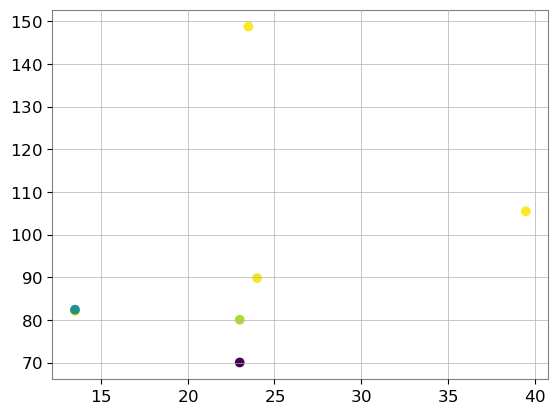

In [73]:
ifos = 'H1L1V1'
ifo1, ifo2, ifo3 = ifos[:2], ifos[2:4], ifos[4:]

df = pd.read_csv('../output_new/tw0.05/predictions/pred_unknown_'+ifos+'.csv')
df = df.loc[:, ~df.columns.str.match('Unnamed')]
print(len(df))
df = df.loc[(df['Prob0_'+ifo1] > 0.9) & (df['Prob0_'+ifo2] > 0.9) & (df['Prob0_'+ifo3] > 0.9) ]
print(len(df))
df = df.loc[(df['Num triggers_'+ifo1] > 10) & (df['Num triggers_'+ifo2] > 10) & (df['Num triggers_'+ifo3] > 10)]
print(len(df))
df = df.loc[(df['Mass_1_'+ifo1] - 3 < df['Mass_1_'+ifo2]) & (df['Mass_1_'+ifo1] + 3 > df['Mass_1_'+ifo2])]
df = df.loc[(df['Mass_1_'+ifo1] - 3 < df['Mass_1_'+ifo3]) & (df['Mass_1_'+ifo1] + 3 > df['Mass_1_'+ifo3])]
print(len(df))
df = df.loc[(df['Mass_2_'+ifo1] - 3 < df['Mass_2_'+ifo2]) & (df['Mass_2_'+ifo1] + 3 > df['Mass_2_'+ifo2])]
df = df.loc[(df['Mass_2_'+ifo1] - 3 < df['Mass_2_'+ifo3]) & (df['Mass_2_'+ifo1] + 3 > df['Mass_2_'+ifo3])]
print(len(df))
df = df.loc[(df['SNR_'+ifo1] - 3 < df['SNR_'+ifo2]) & (df['SNR_'+ifo1] + 3 > df['SNR_'+ifo2])]
df = df.loc[(df['SNR_'+ifo1] - 3 < df['SNR_'+ifo3]) & (df['SNR_'+ifo1] + 3 > df['SNR_'+ifo3])]
print(len(df))
df = df.loc[(df['SNR_'+ifo1] > 4.5) & (df['SNR_'+ifo2] > 4.5) & (df['SNR_'+ifo3] > 4.5)]
print(len(df))
df = df.sort_values(by=['Num triggers_'+ifo1, 'Num triggers_'+ifo2, 'Num triggers_'+ifo3], ascending=False)

chirpmass = (df['Mass_1_'+ifo1]*df['Mass_2_'+ifo1]**(3/5)/(df['Mass_1_'+ifo1]+df['Mass_2_'+ifo1])**(1/5))
plt.scatter((df['Num triggers_'+ifo1]+df['Num triggers_'+ifo2])/2, chirpmass, c=(df['Prob0_'+ifo1]+df['Prob0_'+ifo2])/2)

0 1251420746.4799552 0.99999774 1.0 0.9999558 31.0 48.0 48.0 5.357528700912527 4.8099668915243585 4.970557842183752 58.46441749550066 60.27364277101874 60.009887163758364 10.984288106544225 9.156117335134388 9.163912025191081
 New! 


/data/gravwav/lopezm/cmb_env/miniforge3/envs/ml_course/lib/python3.7/site-packages/gwpy/signal/qtransform.py:126: UserWarning: upper frequency of 2048.00 is too high for the given Q range, resetting to 1291.05
  % (self.frange[1], maxf))


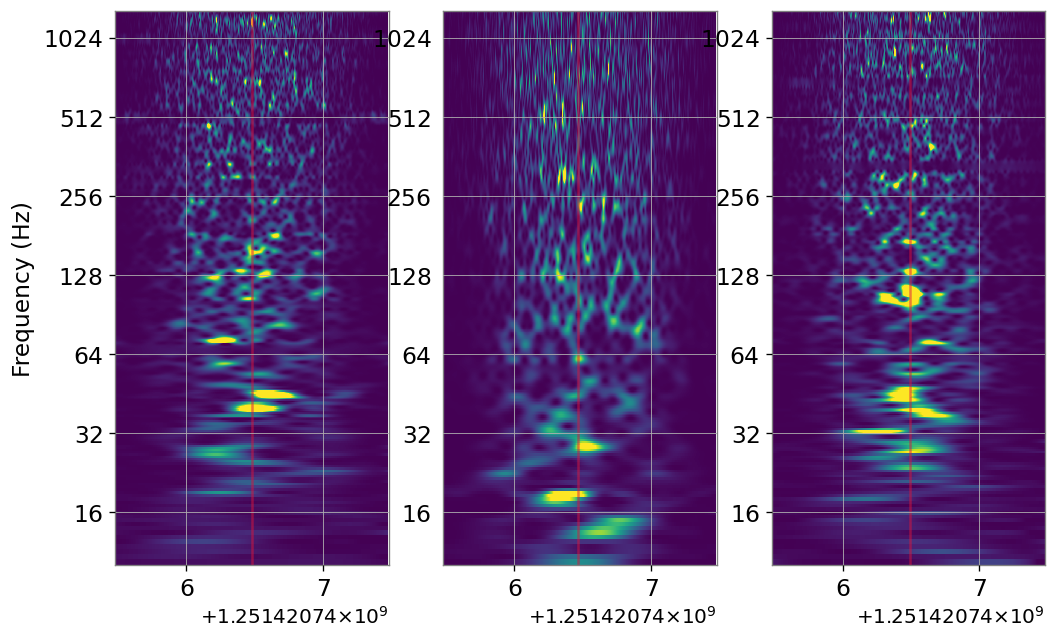

 
1 1262069067.4047625 0.99919647 0.9991285 0.955657 27.0 21.0 27.0 5.14840123489948 4.52510302924407 4.899450060428962 55.50854573418553 56.52889308992477 54.1894437449486 8.938921110467689 9.884086285485118 8.5848127866372
 New! 


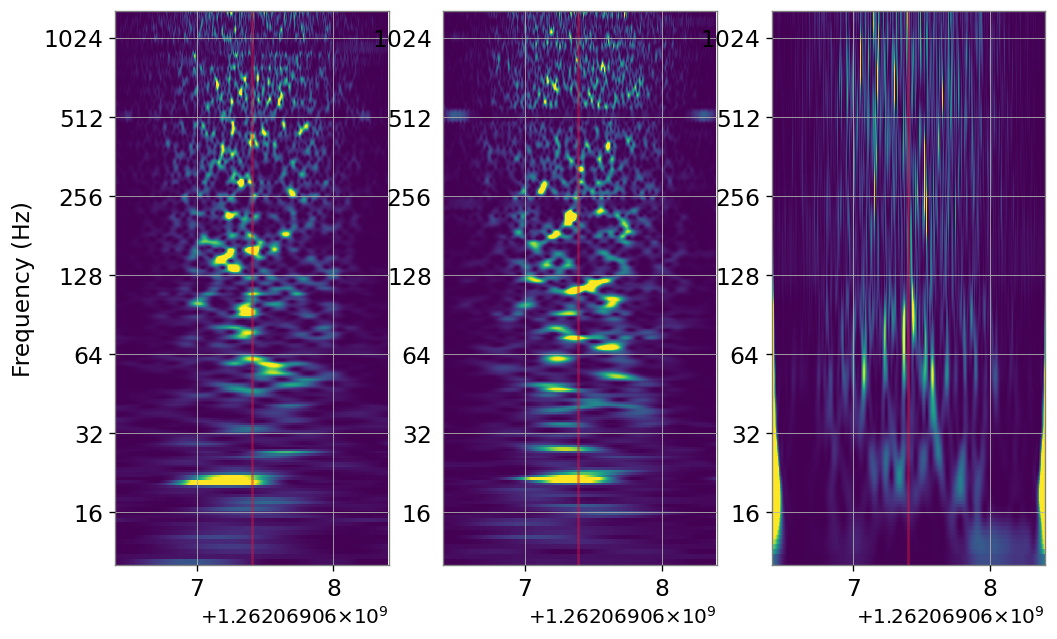

 
2 1251088086.9515483 0.98790956 0.999818 0.98840135 24.0 22.0 20.0 4.568764593846053 5.095759219228058 5.314339692020591 47.04113945031988 46.40866075940857 48.67450725823719 9.297462984144527 9.554329193898415 6.34918512164873
 New! 


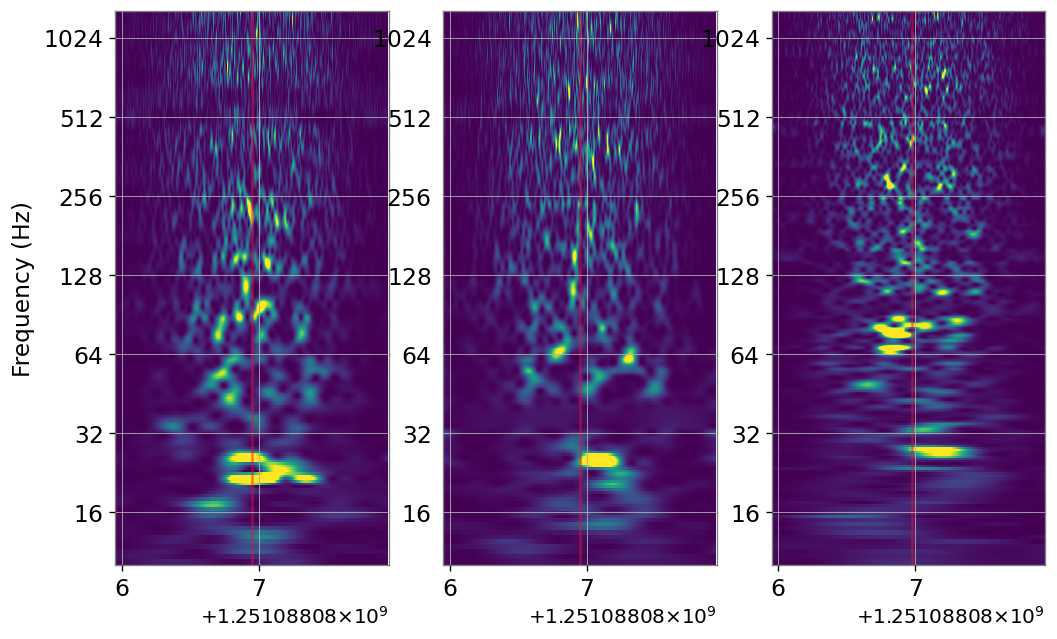

 
3 1241269460.0701554 1.0 1.0 1.0 23.0 24.0 23.0 4.794986283155554 4.815973723080051 4.905160965190658 70.89989934387062 69.43410175244722 70.79390362469496 15.187567243179982 15.039965179897752 14.731297213772953
 New! 


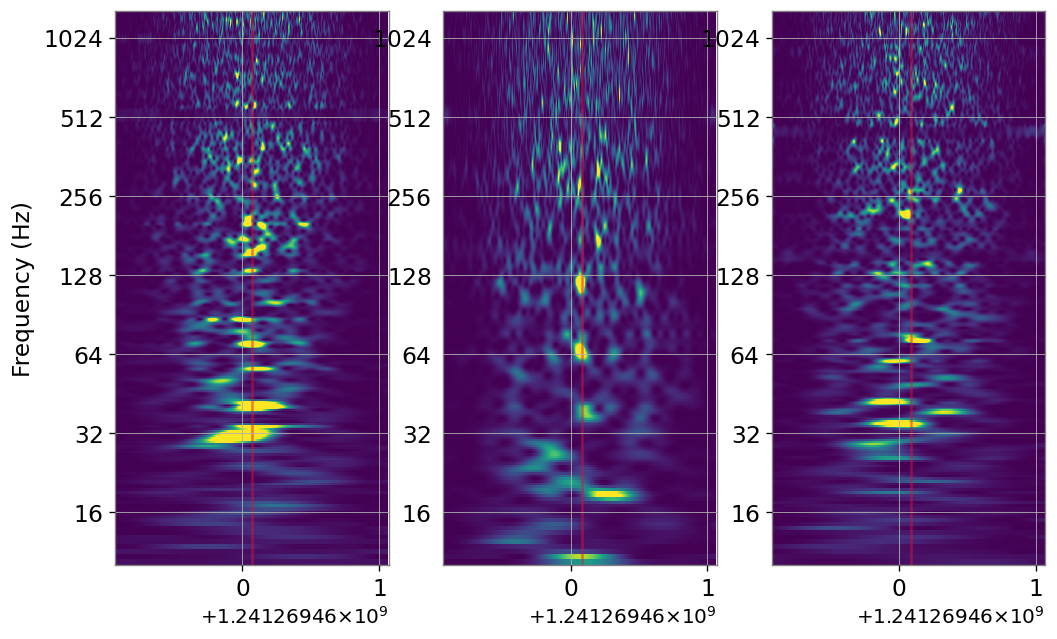

 
4 1242259819.0494125 0.9024719 1.0 0.9998945 23.0 23.0 23.0 4.59345193188201 4.7029177633015085 4.8133471519593405 44.59528184074832 44.728382298877904 44.55901481464756 7.944612264850386 7.7012786525934995 7.9783912752290425
 New! 


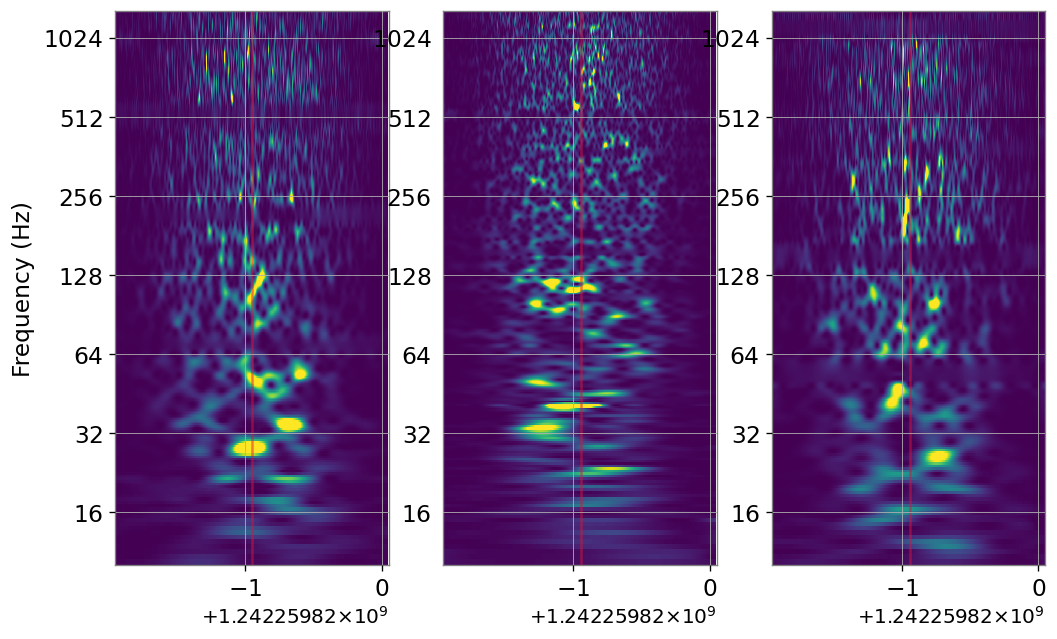

 
5 1262003708.0461512 0.9987078 0.999283 0.9433677 14.0 13.0 14.0 4.540654885878929 4.515794235988385 4.816240903561863 50.66600059241747 49.8096207073625 50.80562842525285 8.722898474494505 8.693487239657879 8.725493665849992
 New! 


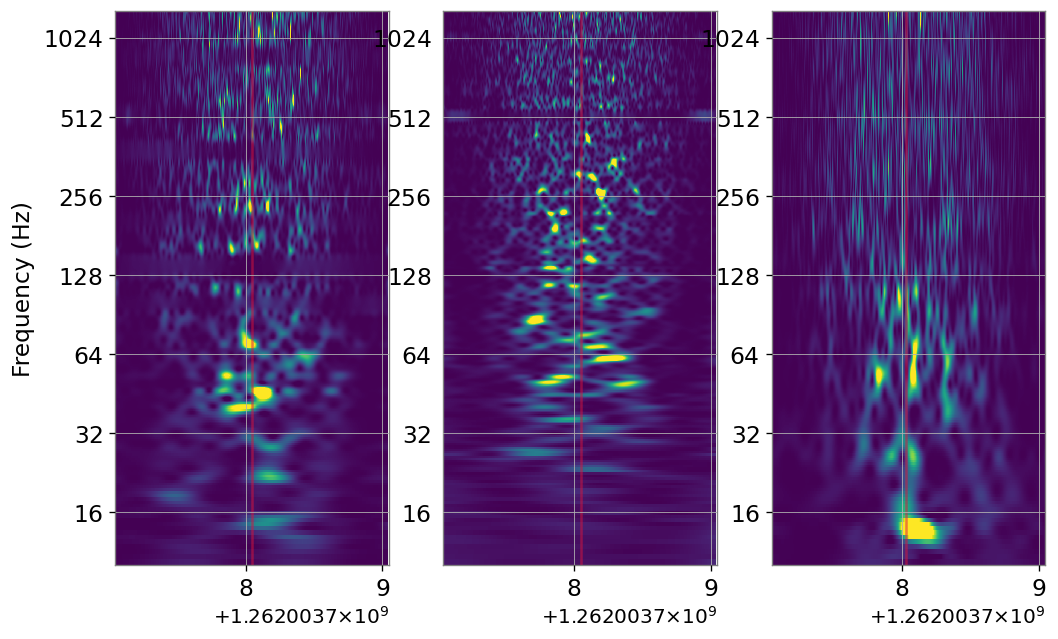

 
6 1250020124.5047512 0.9509312 0.9997708 0.9869153 13.0 14.0 14.0 4.552589839325415 4.691244052192 4.619193323746697 50.278349998857 50.65192853215842 51.12888909644249 8.876646672568803 8.625301515101013 7.861853517943801
 New! 


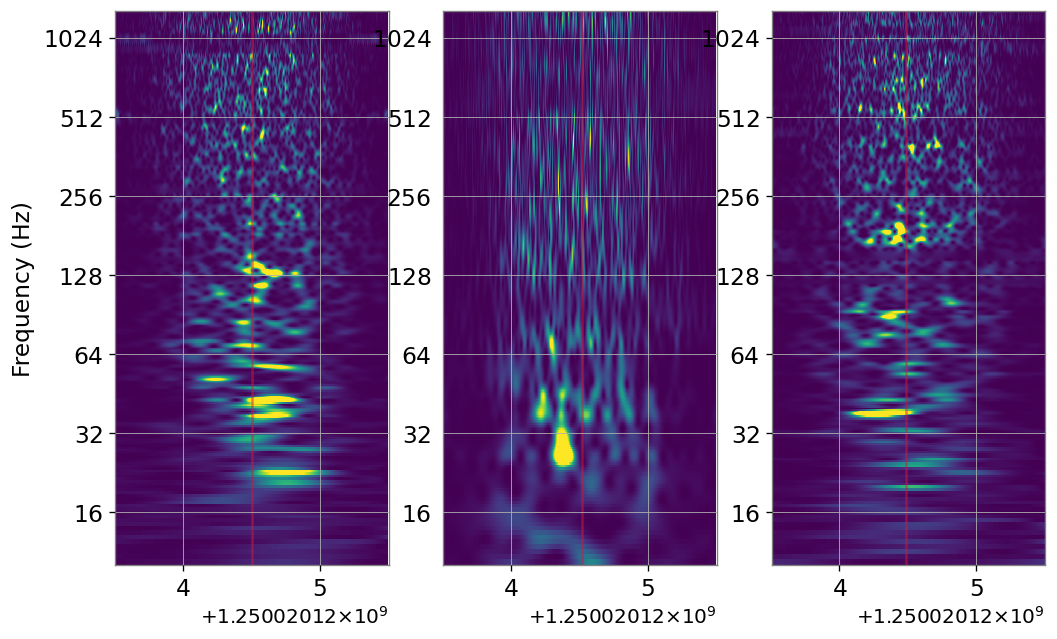

In [77]:
events = pd.read_csv('/data/gravwav/lopezm/Projects/GlitchBank/allevents.csv')
events = events.loc[events['GPS']>1238166018].sort_values(by='GPS')
pars = list()
for t in range(len(df)):
    t_star = df.iloc[t]['Cluster time_'+ifo1]
    print(t, t_star,
              df.iloc[t]['Prob0_'+ifo1], df.iloc[t]['Prob0_'+ifo2], df.iloc[t]['Prob0_'+ifo3],
              df.iloc[t]['Num triggers_'+ifo1], df.iloc[t]['Num triggers_'+ifo2], df.iloc[t]['Num triggers_'+ifo3],
              df.iloc[t]['SNR_'+ifo1], df.iloc[t]['SNR_'+ifo2], df.iloc[t]['SNR_'+ifo3],
              df.iloc[t]['Mass_1_'+ifo1], df.iloc[t]['Mass_1_'+ifo2], df.iloc[t]['Mass_1_'+ifo3],
              df.iloc[t]['Mass_2_'+ifo1], df.iloc[t]['Mass_2_'+ifo2], df.iloc[t]['Mass_2_'+ifo3])
    try:
        gwosc = detectedGWOSC(events, t_star)
    except KeyError as e:
        print(e)
        gwosc = False
    if gwosc:
        print('GWOSC detected')
    else:
        print(' New! ')
        
        pars.append([t_star,
              df.iloc[t]['Prob0_'+ifo1], df.iloc[t]['Prob0_'+ifo2], df.iloc[t]['Prob0_'+ifo3],
              df.iloc[t]['Num triggers_'+ifo1], df.iloc[t]['Num triggers_'+ifo2], df.iloc[t]['Num triggers_'+ifo3],
              df.iloc[t]['SNR_'+ifo1], df.iloc[t]['SNR_'+ifo2], df.iloc[t]['SNR_'+ifo3],
              df.iloc[t]['Mass_1_'+ifo1], df.iloc[t]['Mass_1_'+ifo2], df.iloc[t]['Mass_1_'+ifo3],
              df.iloc[t]['Mass_2_'+ifo1], df.iloc[t]['Mass_2_'+ifo2], df.iloc[t]['Mass_2_'+ifo3]])


        fig, ax = plt.subplots(1, len([ifo1, ifo2, ifo3]), figsize=(10, 6), dpi=120)
        for i, ifo in enumerate([ifo1, ifo2, ifo3]):
            strain = TimeSeries.fetch_open_data(ifo, t_star - 1, t_star + 1)
            # Perform q-transform
            q_scan = strain.q_transform(qrange=[4, 64], frange=[10, 2048],
                                     tres=0.002, fres=0.5, whiten=True)

            # Plot spectrogram
            ax[i].imshow(q_scan, cmap='viridis', vmin=0, vmax=25.5,label=ifo)
            ax[i].axvline(df.iloc[t]['Cluster time_'+ifo], c='crimson', alpha=0.5)
            ax[i].set_yscale('log', base=2)
            ax[i].set_xscale('linear')
            ax[0].set_ylabel('Frequency (Hz)', fontsize=14)
            ax[1].yaxis.set_ticks_position('none')
            #ax[i].set_xlabel('Time (s)', labelpad=0.1, fontsize=14)
            ax[i].yaxis.set_major_formatter(ScalarFormatter())
            ax[i].tick_params(axis='both', which='major', labelsize=14)
        plt.show()
    print(' ')

### Misc

In [3]:
def amazingStat2ifo(tmp_h1, tmp_l1):
    
    ph1 = tmp_h1['Prob0']
    pl1 = tmp_l1['Prob0'].values[0]
    snr_h1 = tmp_h1['SNR']
    snr_l1 = tmp_l1['SNR'].values[0]
    dt = np.abs(th1-tl1)
    dm1 = np.abs(tmp_h1['Mass_1'] - tmp_l1['Mass_1'].values[0])
    dm2 = np.abs(tmp_h1['Mass_2'] - tmp_l1['Mass_2'].values[0])
    sigma_m1 = 1
    sigma_m2 = 1
    sigma_snr = 2
    epsilon = 10**(-12)
    #As2ifo = np.log(ph1*pl1*np.exp((snr_h1 - snr_l1))*np.exp(np.abs(dt))*np.exp(- (dm1/sigma_m1) - (dm2/sigma_m2)))
    As2ifo = ph1*pl1*np.log(np.exp(np.abs(dt))*100 -dm1-dm2 + np.exp(snr_l1)+ np.exp(snr_h1))
    print(np.round(As2ifo, 3), ph1*pl1, np.log(np.exp(np.abs(dt))*1000+ np.exp(-dm1-dm2-epsilon) + np.exp((snr_h1+snr_l1)/sigma_snr)))
    
    #if np.abs(th1 - 1242442967.4) < 0.1:
    #    print('GW', As2ifo, ph1*pl1, np.log(np.exp(np.abs(dt))*1000+ np.exp(-dm1-dm2-epsilon) + np.exp((snr_h1+snr_l1)/sigma_snr)))
    #else:
    #    print(As2ifo, ph1*pl1, np.log(np.exp(np.abs(dt))*1000+ np.exp(-dm1-dm2-epsilon) + np.exp((snr_h1+snr_l1)/sigma_snr)))
    return th1, tl1, As2ifo

In [4]:
Th1, Tl1, As = list(), list(), list()
for i in range(len(pH1_)):
    tmp_h1 = pH1_.iloc[i]
    th1 = tmp_h1['Cluster time']
    tmp_l1 = pL1_[(pL1_['Cluster time'] > th1 -0.03) & (pL1_['Cluster time'] < th1 +0.03)]
    
    if len(tmp_l1) != 0:
        tl1 = tmp_l1['Cluster time'].values[0]
        #if (np.asarray(tmp_h1['Prob0']) > 0.9) and (np.asarray(tmp_l1['Prob0'].values[0]) > 0.9):

        ph1 = tmp_h1['Prob0']
        pl1 = tmp_l1['Prob0'].values[0]
        snr_h1 = tmp_h1['SNR']
        snr_l1 = tmp_l1['SNR'].values[0]
        dt = np.abs(th1-tl1)
        dm1 = np.abs(tmp_h1['Mass_1'] - tmp_l1['Mass_1'].values[0])
        dm2 = np.abs(tmp_h1['Mass_2'] - tmp_l1['Mass_2'].values[0])
        sigma_m1 = 2
        sigma_m2 = 2

        th1, tl1, stat = amazingStat2ifo(tmp_h1, tmp_l1)
        #if stat < -50:
        #print(th1 - tl1, stat)
        #q_scan = QScanht(th1-2, th1+2, 'H1')
        #plot(q_scan, th1-2, th1, th1+2)

        #q_scan = QScanht(tl1-2, tl1+2, 'L1')
        #plot(q_scan, tl1-2,tl1, tl1+2)
#print(th1 - tl1)

NameError: name 'pH1_' is not defined

In [177]:
display(pH1.loc[i].values)
print(pH1.columns.values)
pd.DataFrame(pH1.loc[i].values.reshape(1, -1), columns=pH1.columns)

array([ 5.12206320e+00,  9.55382530e-01,  3.94408340e+01,
        1.12026970e+01, -2.82003310e-01, -3.86371310e-01,
        9.51180300e-04,  6.55757500e-02,  3.34000000e-43,
        5.04718660e-10,  0.00000000e+00,  9.33473050e-01,
        2.93718530e-35,  5.04000000e+03,  1.23820792e+09])

['SNR' 'Chisq' 'Mass_1' 'Mass_2' 'Spin1z' 'Spin2z' 'Prob0'
 'Prob1' 'Prob2' 'Prob3' 'Prob4' 'Prob5' 'Prob6' 'Cluster ID'
 'Cluster time']


SNR     Chisq     Mass_1     Mass_2    Spin1z    Spin2z     Prob0  \
0  5.122063  0.955383  39.440834  11.202697 -0.282003 -0.386371  0.000951   

      Prob1         Prob2         Prob3  Prob4     Prob5         Prob6  \
0  0.065576  3.340000e-43  5.047187e-10    0.0  0.933473  2.937185e-35   

   Cluster ID  Cluster time  
0      5040.0  1.238208e+09

In [ ]:
tmp = pd.concat([tmp_h1, tmp_l1], axis=1)
tmp_h1.join(tmp_l1, lsuffix="_H1", rsuffix=("_L1"))


In [179]:
Th1, Tl1, As = list(), list(), list()
columns = pH1.columns
all_rows = list()
for i in range(len(pH1_)):
    tmp_h1 = pH1_.iloc[[i]].reset_index()
    th1 = tmp_h1['Cluster time'].values[0]
    tmp_l1 = pL1_[(pL1_['Cluster time'] > th1 -0.03) & (pL1_['Cluster time'] < th1 +0.03)].reset_index()
    
    if len(tmp_l1) != 0:
        tmp = tmp_h1.join(tmp_l1, lsuffix="_H1", rsuffix=("_L1"))
        all_rows.append(tmp.values[0])

In [2]:
merged = pd.DataFrame(all_rows, columns=tmp.columns)
gw190521 = merged[(merged['Cluster time_H1'] > 1242442967.4 -1) & (merged['Cluster time_H1'] < 1242442967.4 +1)]

NameError: name 'all_rows' is not defined

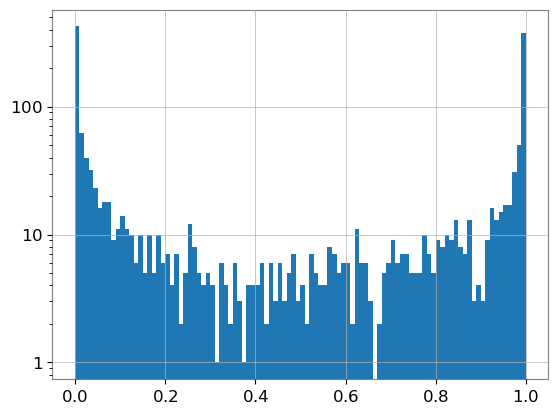

In [185]:
plt.hist(merged['Prob0_H1'], bins=100)
plt.yscale('log')

(array([ 24., 111., 216., 233., 257., 269., 246., 212.,  87.,
         16.]),
 array([-0.02910447, -0.02321193, -0.01731939, -0.01142685,
        -0.00553432,  0.00035822,  0.00625076,  0.0121433 ,
         0.01803584,  0.02392838,  0.02982092]),
 <BarContainer object of 10 artists>)

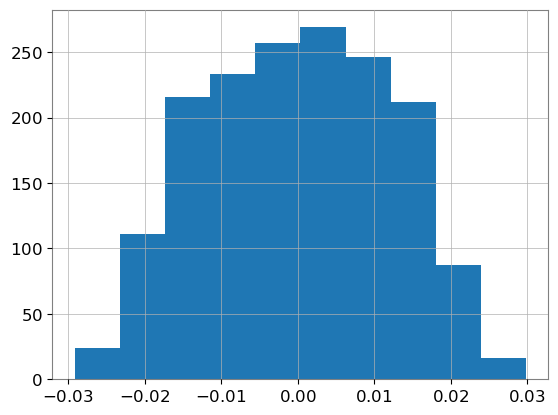

In [181]:
plt.hist(merged['Cluster time_H1']-merged['Cluster time_L1'])

In [186]:

ds1 = np.abs(merged['Spin1z_H1']-merged['Spin1z_L1'])
ds2 = np.abs(merged['Spin2z_H1']-merged['Spin2z_L1'])
dm1 = np.abs(merged['Mass_1_H1']-merged['Mass_1_L1'])
dm2 = np.abs(merged['Mass_2_H1']-merged['Mass_2_L1'])
dt = np.abs(merged['Cluster time_H1']-merged['Cluster time_L1'])
ph1 = merged['Prob0_H1']
pl1 = merged['Prob0_L1']
netSNR = np.sqrt(merged['SNR_H1']**2 +merged['SNR_L1']**2)
netChisq = np.sqrt(merged['Chisq_H1']**2+merged['Chisq_L1']**2)

ds1gw = np.abs(gw190521['Spin1z_H1']-gw190521['Spin1z_L1'])
ds2gw = np.abs(gw190521['Spin2z_H1']-gw190521['Spin2z_L1'])
dm1gw = np.abs(gw190521['Mass_1_H1']-gw190521['Mass_1_L1'])
dm2gw = np.abs(gw190521['Mass_2_H1']-gw190521['Mass_2_L1'])
dtgw = np.abs(gw190521['Cluster time_H1']-gw190521['Cluster time_L1'])
ph1gw = gw190521['Prob0_H1']
pl1gw = gw190521['Prob0_L1']
netSNRgw = np.sqrt(gw190521['SNR_H1']**2 + gw190521['SNR_L1']**2)
netChisqgw = np.sqrt(gw190521['Chisq_H1']**2+gw190521['Chisq_L1']**2)


merged.columns

Index(['index_H1', 'SNR_H1', 'Chisq_H1', 'Mass_1_H1', 'Mass_2_H1', 'Spin1z_H1',
       'Spin2z_H1', 'Prob0_H1', 'Prob1_H1', 'Prob2_H1', 'Prob3_H1', 'Prob4_H1',
       'Prob5_H1', 'Prob6_H1', 'Cluster ID_H1', 'Cluster time_H1', 'index_L1',
       'SNR_L1', 'Chisq_L1', 'Mass_1_L1', 'Mass_2_L1', 'Spin1z_L1',
       'Spin2z_L1', 'Prob0_L1', 'Prob1_L1', 'Prob2_L1', 'Prob3_L1', 'Prob4_L1',
       'Prob5_L1', 'Prob6_L1', 'Cluster ID_L1', 'Cluster time_L1'],
      dtype='object')

1094    0.691108
dtype: float64


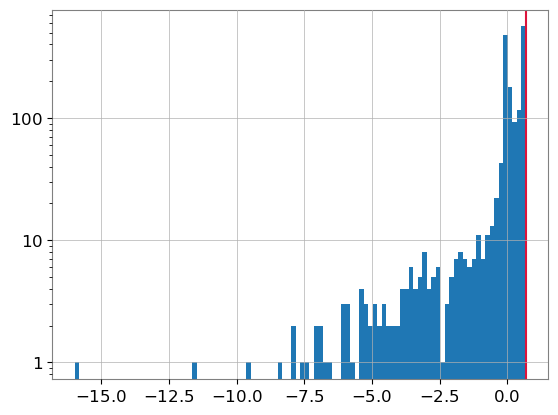

In [187]:
def amazingStat(ds1, ds2, dm1, dm2, dt, ph1, pl1, netSNR, netChisq):
    epsilon =10**(-12)
    #ams = np.log((ph1*pl1)/2*np.exp(-ds1-ds2-dm1-dm2-dt+netSNR))
    ams = np.log(pl1+ph1)
    #ams = (ph1*pl1*np.exp(-dt+netSNR-(ds1+ds2+epsilon)/2-(dm1 +dm2+epsilon)/2+netChisq))
    return ams

print(amazingStat(ds1gw, ds2gw, dm1gw, dm2gw, dtgw, ph1gw, pl1gw, netSNRgw, netChisqgw))
plt.hist(amazingStat(ds1, ds2, dm1, dm2, dt, ph1, pl1, netSNR, netChisq).values, bins=100)
plt.axvline(amazingStat(ds1gw, ds2gw, dm1gw, dm2gw, dtgw, ph1gw, pl1gw, netSNRgw, netChisqgw).values, c='crimson')
plt.yscale('log')


In [196]:
merged['SNR_L1']

0       4.141871
1       4.385252
2       4.101066
3       4.167203
4       4.094711
          ...   
1666    4.417823
1667    5.181598
1668    4.433145
1669    5.408497
1670    4.659464
Name: SNR_L1, Length: 1671, dtype: float64

In [206]:
merged

index_H1    SNR_H1  Chisq_H1  Mass_1_H1  Mass_2_H1  Spin1z_H1  \
0     335929.0  5.504354  1.216764  42.242497   9.939208   0.937476   
1     335933.0  4.337716  0.571162  74.076344   8.179716   0.907492   
2     335940.0  4.431832  0.779133  52.862414   5.686511  -0.918176   
3     335942.0  4.177088  1.183540  83.740386  10.077686   0.866274   
4     335943.0  4.242392  1.185355  73.949013  10.798553   0.979575   
...        ...       ...       ...        ...        ...        ...   
1666  340960.0  5.502688  0.870507  56.644993   6.525756   0.969895   
1667  340962.0  5.178270  0.998766  47.378820   8.715445  -0.695802   
1668  340964.0  5.483469  1.096538  44.125382   6.327168   0.866262   
1669  340966.0  4.497471  1.325740  45.466864   5.293616   0.885530   
1670  340969.0  5.258771  1.363813  45.709526   4.600135   0.636995   

      Spin2z_H1      Prob0_H1      Prob1_H1      Prob2_H1  ...  Spin2z_L1  \
0      0.696860  1.082480e-10  1.052800e-10  5.226650e-30  ...   0.647409   
1     -0.452376  9.433743e-01  3.368044e-24  0.000000e+00  ...  -0.445660   
2      0.054993  7.037326e-01  6.222820e-24  1.000000e-45  ...   0.054713   
3      0.570191  1.884006e-01  1.057721e-24  2.333606e-38  ...   0.566264   
4     -0.969314  9.525005e-01  6.776906e-03  0.000000e+00  ...  -0.969314   
...         ...           ...           ...           ...  ...        ...   
1666  -0.795147  6.784990e-02  4.852498e-11  1.453236e-39  ...  -0.795147   
1667  -0.245646  9.997788e-01  6.090972e-07  1.066000e-42  ...  -0.246502   
1668   0.161709  2.577026e-01  7.243213e-13  6.172498e-27  ...   0.155271   
1669  -0.904661  4.592817e-01  4.598828e-06  1.317823e-31  ...  -0.904601   
1670  -0.658684  5.312263e-05  1.229724e-10  8.881012e-28  ...  -0.658684   

      Prob0_L1      Prob1_L1      Prob2_L1      Prob3_L1      Prob4_L1  \
0     0.020874  7.528163e-22  1.284175e-27  9.791264e-01  1.058950e-38   
1     1.000000  1.724178e-22  4.841650e-37  3.444925e-19  0.000000e+00   
2     0.990589  1.657566e-12  4.280655e-15  9.409504e-03  5.694222e-32   
3     1.000000  4.360502e-15  3.470730e-31  9.291057e-09  1.405185e-27   
4     1.000000  3.190380e-32  0.000000e+00  3.749617e-18  0.000000e+00   
...        ...           ...           ...           ...           ...   
1666  1.000000  1.510665e-11  0.000000e+00  1.331121e-16  0.000000e+00   
1667  1.000000  7.622361e-22  0.000000e+00  1.537342e-28  6.327377e-32   
1668  0.997979  1.006534e-25  1.060241e-23  1.638180e-12  2.266520e-40   
1669  1.000000  1.450758e-13  0.000000e+00  2.116804e-07  0.000000e+00   
1670  0.999177  1.360112e-31  0.000000e+00  8.233998e-04  0.000000e+00   

          Prob5_L1      Prob6_L1  Cluster ID_L1  Cluster time_L1  
0     3.854459e-26  3.399623e-14        62426.0     1.242423e+09  
1     1.157837e-37  1.460092e-09        62432.0     1.242423e+09  
2     0.000000e+00  1.905000e-06        62441.0     1.242423e+09  
3     2.504373e-27  3.362249e-07        62442.0     1.242423e+09  
4     1.380338e-27  2.347520e-11        62443.0     1.242423e+09  
...            ...           ...            ...              ...  
1666  1.117761e-08  9.204244e-09        67509.0     1.242462e+09  
1667  0.000000e+00  8.968101e-19        67513.0     1.242462e+09  
1668  3.329493e-04  1.688237e-03        67515.0     1.242463e+09  
1669  3.470595e-10  8.974009e-10        67517.0     1.242463e+09  
1670  2.060592e-09  3.082405e-14        67519.0     1.242463e+09  

[1671 rows x 32 columns]

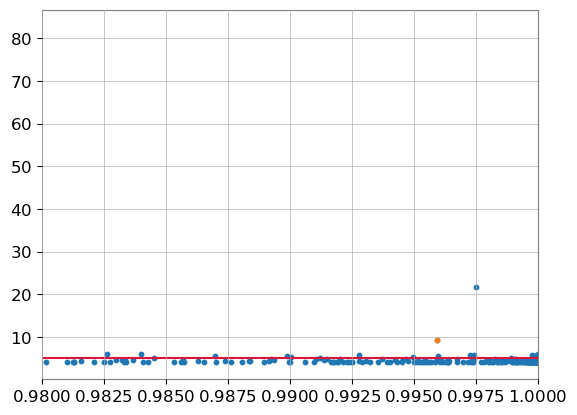

In [199]:
plt.scatter(ph1*pl1, merged['SNR_L1'], s=10)
plt.scatter(ph1gw*pl1gw, gw190521['SNR_L1'], s=10)
plt.xlim(0.98, 1)
#plt.ylim(0, 20)
plt.axhline(5, c='crimson')
#plt.xscale('log')
#plt.yscale('log')

In [1179]:
ph1gw*pl1gw

1094    0.995926
dtype: float64

(array([559.,  70.,  44.,  33.,  18.,  16.,  20.,  17.,  13.,
          8.,   9.,  13.,  10.,   6.,  11.,   3.,  12.,   8.,
          6.,   6.,   9.,   4.,   5.,   3.,   5.,   9.,   6.,
          5.,   7.,   3.,   2.,   5.,   5.,   2.,   0.,   7.,
          6.,   0.,   4.,   5.,   3.,   7.,   3.,   3.,   3.,
          8.,   1.,   6.,   5.,   1.,   4.,   1.,   6.,   3.,
          4.,   5.,   8.,   8.,   7.,   5.,   4.,   5.,  10.,
          6.,   7.,   1.,   2.,   1.,   7.,   6.,   6.,   7.,
          8.,   5.,   5.,   3.,   3.,  10.,   0.,   5.,   7.,
         10.,   8.,   8.,  10.,   7.,   5.,   9.,   4.,   3.,
          4.,   8.,  16.,  11.,  12.,  13.,  16.,  28.,  39.,
        287.]),
 array([6.81726183e-36, 1.00000000e-02, 2.00000000e-02,
        3.00000000e-02, 4.00000000e-02, 5.00000000e-02,
        6.00000000e-02, 7.00000000e-02, 8.00000000e-02,
        9.00000000e-02, 1.00000000e-01, 1.10000000e-01,
        1.20000000e-01, 1.30000000e-01, 1.40000000e-01,
        1.50000000e-01

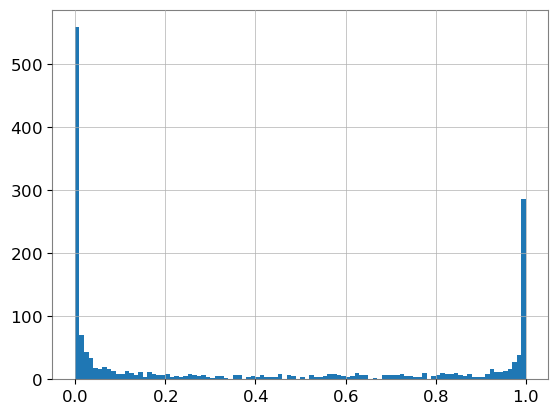

In [1174]:
plt.hist(ph1*pl1, bins=100)

In [1154]:
np.log(pl1gw*ph1gw)

1094   -0.004083
dtype: float64

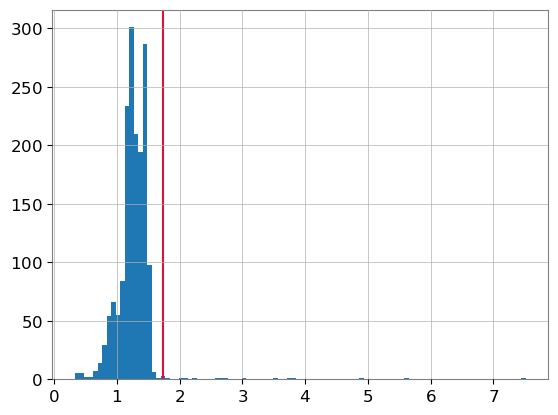

In [1141]:

plt.hist(np.log(pl1+ph1+netChisq + np.exp(-dm1-dm2-ds1-ds2)), bins=100)
plt.axvline(np.log(pl1gw+ph1gw+netChisqgw + np.exp(-dm1gw-dm2gw-ds1gw-ds2gw)).values, c='crimson')

In [1110]:
np.log(pl1gw*ph1gw + np.exp(-dm1gw-dm2gw-ds1gw-ds2gw)+netChisqgw).values, netChisqgw, netChisq[np.argmax(np.log(pl1*ph1 + np.exp(-dm1-dm2-ds1-ds2)+netChisq))]

(array([1.55001182]),
 1094    3.710678
 dtype: float64,
 1843.7926074433542)

In [1076]:
max(dm1)

400.26221254816517

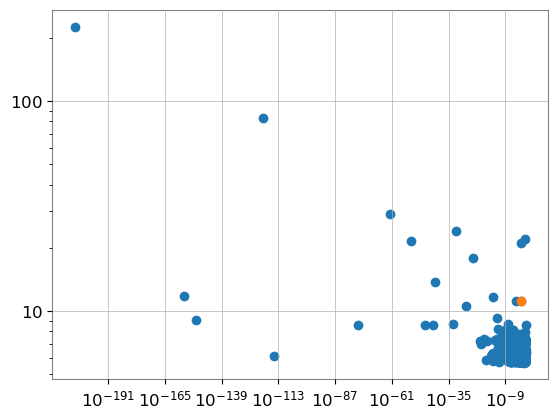

In [1070]:
plt.scatter(ph1*pl1*netChisq*np.exp(-ds1-dm1), netSNR)
plt.scatter(ph1gw*pl1gw*netChisqgw*np.exp(-ds1gw-dm1gw), netSNRgw)
plt.yscale('log')
plt.xscale('log')

In [1045]:
a = np.argmin(amazingStat(ds1, ds2, dm1, dm2, dt, ph1, pl1, netSNR, netChisq))
display(merged.iloc[[a]]['Prob0_H1'])
amazingStat(ds1, ds2, dm1, dm2, dt, ph1, pl1, netSNR, netChisq).values.sum()

667    6.817387e-36
Name: Prob0_H1, dtype: float64

480.8597926121278

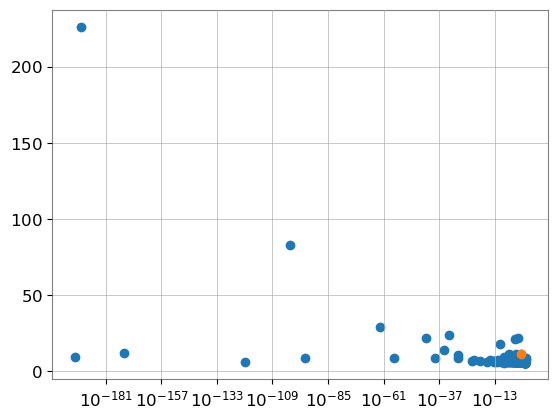

In [980]:
plt.scatter(amazingStat(ds1, ds2, dm1, dm2, dt, ph1, pl1, netSNR, netChisq), np.sqrt(merged['SNR_H1']**2+merged['SNR_L1']**2))
plt.scatter(amazingStat(ds1gw, ds2gw, dm1gw, dm2gw, dtgw, ph1gw, pl1gw, netSNRgw, netChisqgw), np.sqrt(gw190521['SNR_H1']**2+gw190521['SNR_L1']**2))
plt.xscale('log')

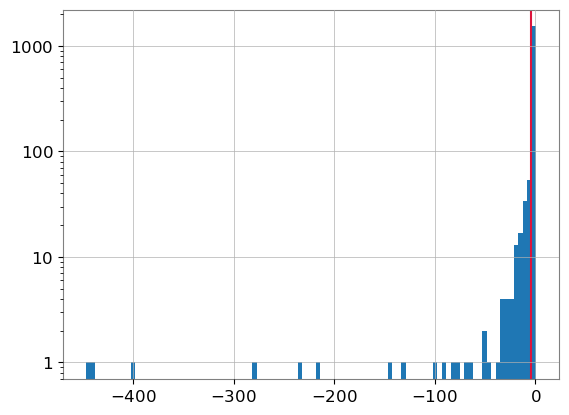

In [985]:
plt.hist(amazingStat(ds1, ds2, dm1, dm2, dt, ph1, pl1, netSNR, netChisq).values, bins=100)
plt.axvline(amazingStat(ds1gw, ds2gw, dm1gw, dm2gw, dtgw, ph1gw, pl1gw, netSNRgw, netChisqgw).values, c='crimson')
plt.yscale('log')

In [662]:
np.argmax(amazingStat(ds1, ds2, dm1, dm2, dt, ph1, pl1, netSNR))

68

In [670]:
merged.iloc[68]['Prob0_L1']

0.9839279000000001

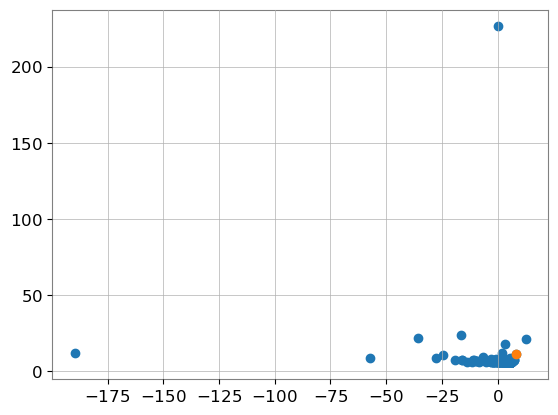

In [673]:
plt.scatter(amazingStat(ds1, ds2, dm1, dm2, dt, ph1, pl1, netSNR), np.sqrt(merged['SNR_H1']**2+merged['SNR_L1']**2))
plt.scatter(amazingStat(ds1gw, ds2gw, dm1gw, dm2gw, dtgw, ph1gw, pl1gw, netSNRgw), np.sqrt(gw190521['SNR_H1']**2+gw190521['SNR_L1']**2))
plt.

In [582]:
Th1, Tl1, As = list(), list(), list()
for i in range(10000):
    tmp_h1 = pH1.iloc[i]
    th1 = tmp_h1['Cluster time']
    tmp_l1 = pL1[(pL1['Cluster time'] > th1 -0.03) & (pL1['Cluster time'] < th1 +0.03)]
    
    if len(tmp_l1) != 0:
        tl1 = tmp_l1['Cluster time'].values[0]

        th1, tl1, stat = amazingStat2ifo(tmp_h1, tmp_l1)

        #if stat > 9:
        #    print(tmp_h1['Prob0'], tmp_l1['Prob0'].values[0])
        #    print(tmp_h1['SNR'], tmp_l1['SNR'].values[0])
        #    print(np.abs(tmp_h1['Mass_1'] - tmp_l1['Mass_1'].values[0]), np.abs(tmp_h1['Mass_2'] - tmp_l1['Mass_2'].values[0]))
        #    print(np.abs(th1-tl1))
        #    print(' ')

        #print(pH1.iloc[i]['Prob0'], ph1*pl1)
        #display(tmp_l1)

        #q_scan = QScanht(th1-2, th1+2, 'H1')
        #plot(q_scan, th1-2, th1, th1+2)

        #q_scan = QScanht(tl1-2, tl1+2, 'L1')
        #plot(q_scan, tl1-2,tl1, tl1+2)

        Th1.append(th1)
        Tl1.append(th1)
        As.append(stat)
        #if stat > 0:
        #print(th1 - tl1, stat)
        #q_scan = QScanht(th1-2, th1+2, 'H1')
        #plot(q_scan, th1-2, th1, th1+2)

        #q_scan = QScanht(tl1-2, tl1+2, 'L1')
        #plot(q_scan, tl1-2,tl1, tl1+2)
#print(th1 - tl1)

0.001 0.00013359569164780318 7.059087669686809
1.106 0.18427156 7.051156587535167
0.0 2.006096180805188e-09 6.9960879673373215
0.0 3.3910017186059696e-05 7.043981010854159
4.41 0.8091133 6.979860716461582
0.004 0.0006383971606899949 7.011331383048613
0.0 5.2249060888978005e-06 7.783322204402708
0.0 5.37759332027748e-06 7.073018141392847
0.002 0.000398969687973504 6.970954742326363
5.554 1.0 6.999373741991762
5.531 0.999730054170075 6.986651332460021
0.008 0.001544423034328944 6.980582712911048
0.0 1.2640736978564396e-08 6.9952249732368195
0.328 0.060720567 6.974622224388539
2.327 0.42798123 6.979153453961414
0.001 0.00023703258079413441 6.975404620909824
3.51 0.64219767 6.991002609009656
5.389 0.99999535 6.969934773809787
0.625 0.1157887284765909 6.972953701672525
5.443 0.9999899999999999 6.975664427686883
0.246 0.04485854 6.983221246366271
0.0 4.1209441346685004e-06 6.993283482611812
5.464 1.0 7.024403443031861
1.713 0.30211260255449995 7.012271645537434
0.0 5.48132143383552e-07 7.056

(array([1.769e+03, 7.750e+02, 2.440e+02, 6.000e+00, 2.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0.        ,  2.7400914 ,  5.4801828 ,  8.2202742 ,
        10.9603656 , 13.700457  , 16.4405484 , 19.1806398 ,
        21.9207312 , 24.66082259, 27.40091399]),
 <BarContainer object of 10 artists>)

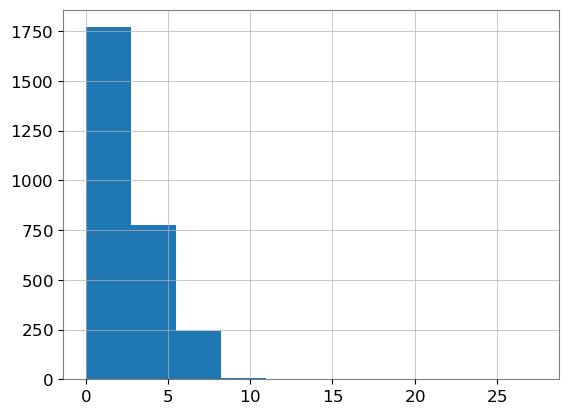

In [583]:
plt.hist(As)

In [314]:
Th1, Tl1, As = list(), list(), list()
for i in range(len(pH1_)):
    tmp_h1 = pH1_.iloc[i]
    th1 = tmp_h1['Cluster time']
    tmp_l1 = pL1_[(pL1_['Cluster time'] > th1 -0.03) & (pL1_['Cluster time'] < th1 +0.03)]
    
    if len(tmp_l1) != 0:
        tl1 = tmp_l1['Cluster time'].values[0]
        #if (np.asarray(tmp_h1['Prob0']) > 0.9) and (np.asarray(tmp_l1['Prob0'].values[0]) > 0.9):

        ph1 = tmp_h1['Prob0']
        pl1 = tmp_l1['Prob0'].values[0]
        snr_h1 = tmp_h1['SNR']
        snr_l1 = tmp_l1['SNR'].values[0]
        dt = np.abs(th1-tl1)
        dm1 = np.abs(tmp_h1['Mass_1'] - tmp_l1['Mass_1'].values[0])
        dm2 = np.abs(tmp_h1['Mass_2'] - tmp_l1['Mass_2'].values[0])
        sigma_m1 = 2
        sigma_m2 = 2

        th1, tl1, stat = amazingStat2ifo(tmp_h1, tmp_l1)
        #if stat < -50:
        print(th1 - tl1, stat)
        #q_scan = QScanht(th1-2, th1+2, 'H1')
        #plot(q_scan, th1-2, th1, th1+2)

        #q_scan = QScanht(tl1-2, tl1+2, 'L1')
        #plot(q_scan, tl1-2,tl1, tl1+2)
#print(th1 - tl1)

0.004671573638916016 14.031123220302002
-0.014748096466064453 0.20429474946280152
-0.008308172225952148 11.811773165374063
0.0068318843841552734 57.05729832339619
0.024204015731811523 17.556157973161397


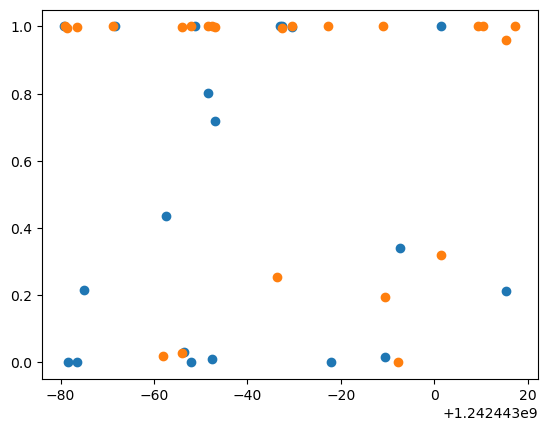

In [135]:
plt.scatter(tH1['Cluster ID'], dH1['Probability'])
plt.scatter(tL1['Cluster ID'], dL1['Probability'])

In [96]:
ytestH1, ltestH1 = predictions(dH1, modelH1)
ytestL1, ltestL1 = predictions(dL1, modelL1)

(20, 6) (20,)
(23, 6) (23,)


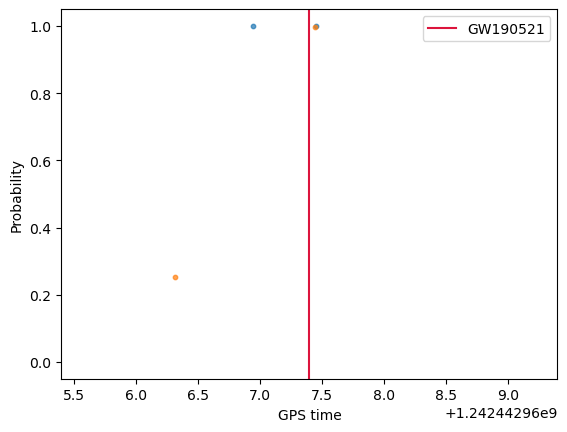

In [107]:
plt.scatter(tH1['Cluster ID'], ytestH1[:, 0], s=10,alpha=0.7)
plt.scatter(tL1['Cluster ID'], ytestL1[:, 0], s=10,alpha=0.7)
plt.axvline(1242442967.4, c='crimson', label='GW190521')
plt.xlim(1242442967.4-2, 1242442967.4+2)
plt.ylabel('Probability')
plt.xlabel('GPS time')
plt.legend()

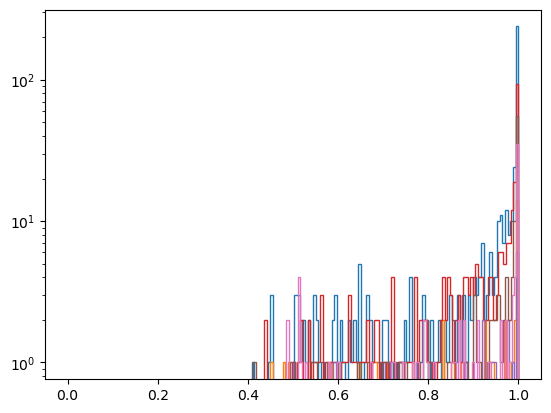

In [53]:
for i in range(7):
    plt.hist(y_pred[np.where(pred_labels == i)][:, i].detach().numpy(), histtype ='step', bins =100)
plt.yscale('log')
plt.

### O3b analysis

*Class tags*

```
if 'Injections' in file_name: t = 0

if 'Blip' in file_name: t = 1

if 'Koi_Fish' in file_name: t = 2

if 'Low_Frequency_Burst' in file_name: t = 3

if 'Tomte' in file_name: t = 4

if 'Whistle' in file_name: t = 5

if 'Fast_Scattering' in file_name:t = 6
```

In [35]:
!ls ../output_new/tw0.05/predictions

pred_known_H1_O3b.csv  pred_known_V1_O3b.csv  pred_unknown_L1.csv
pred_known_L1_O3b.csv  pred_unknown_H1.csv    pred_unknown_V1.csv


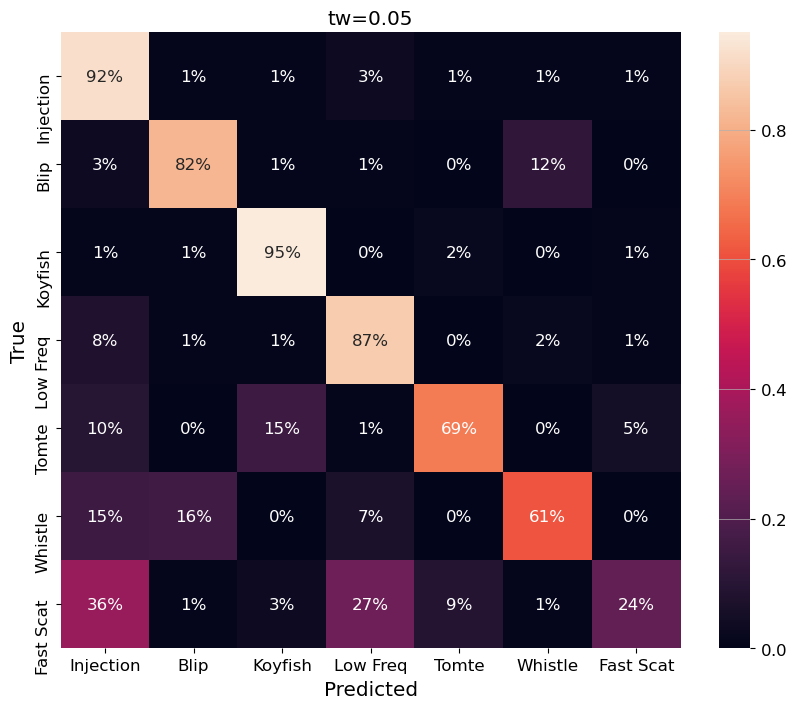

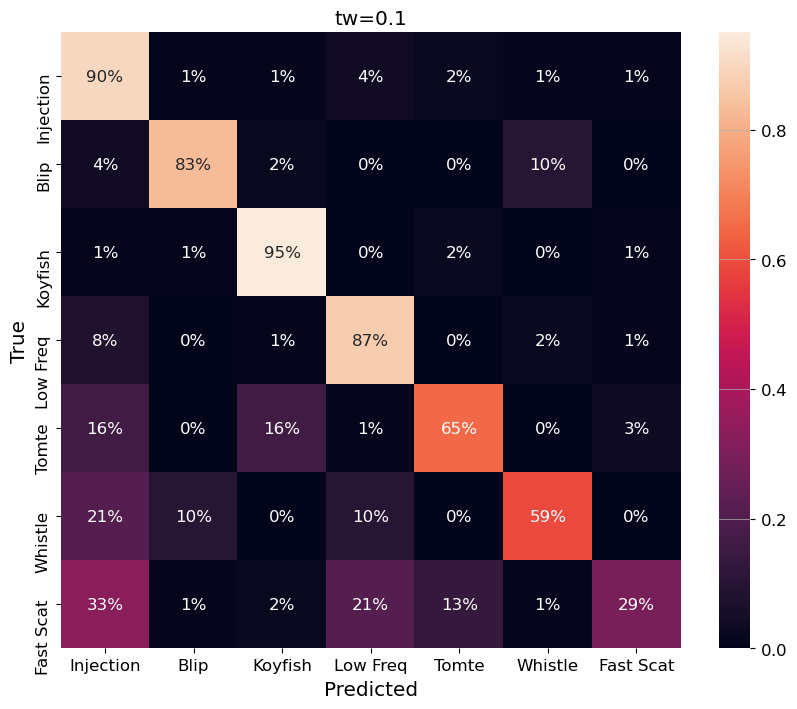

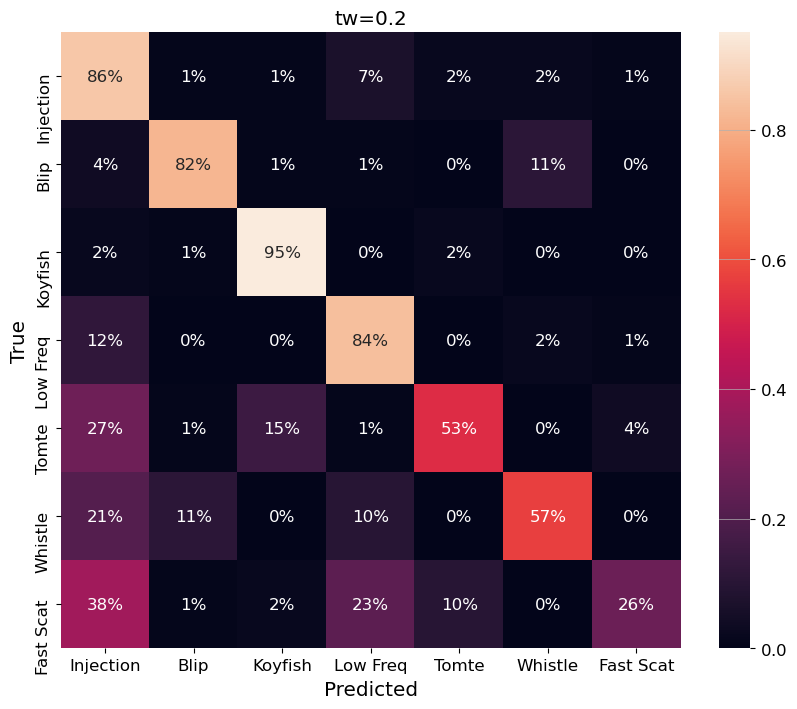

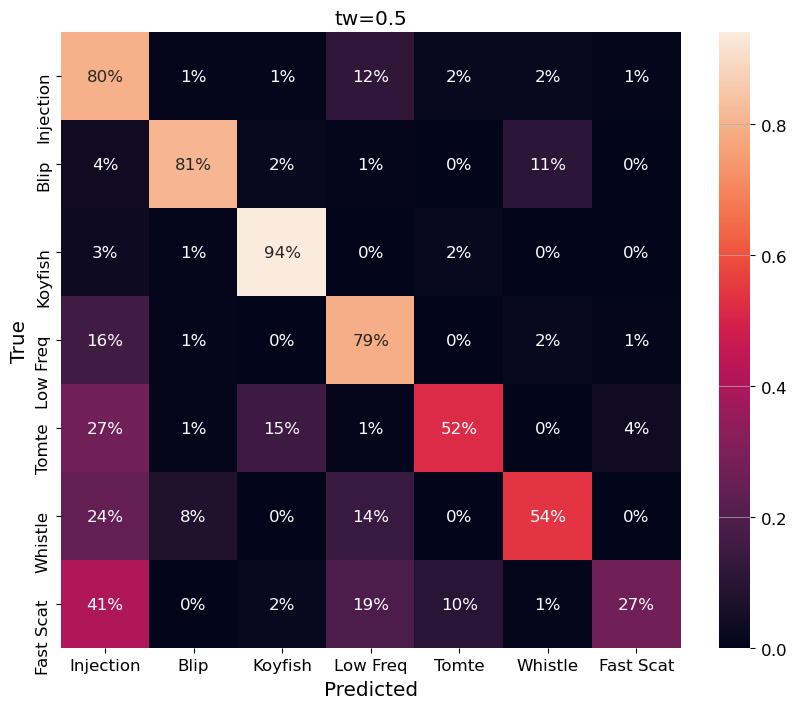

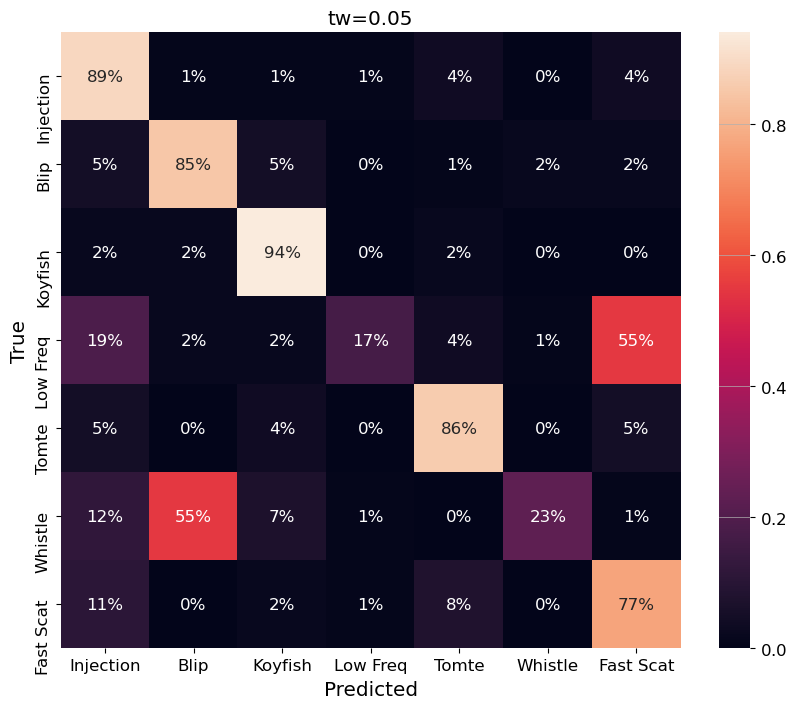

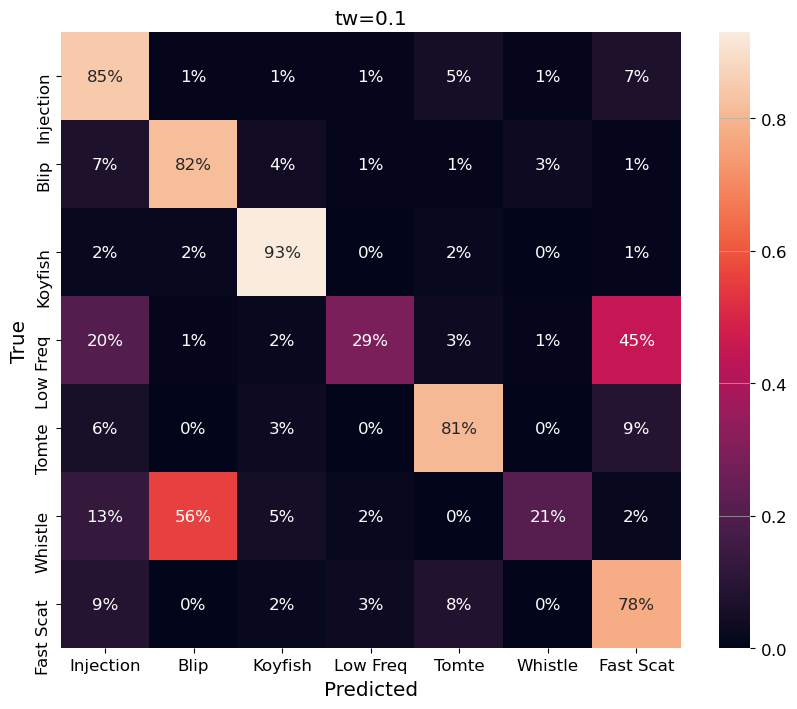

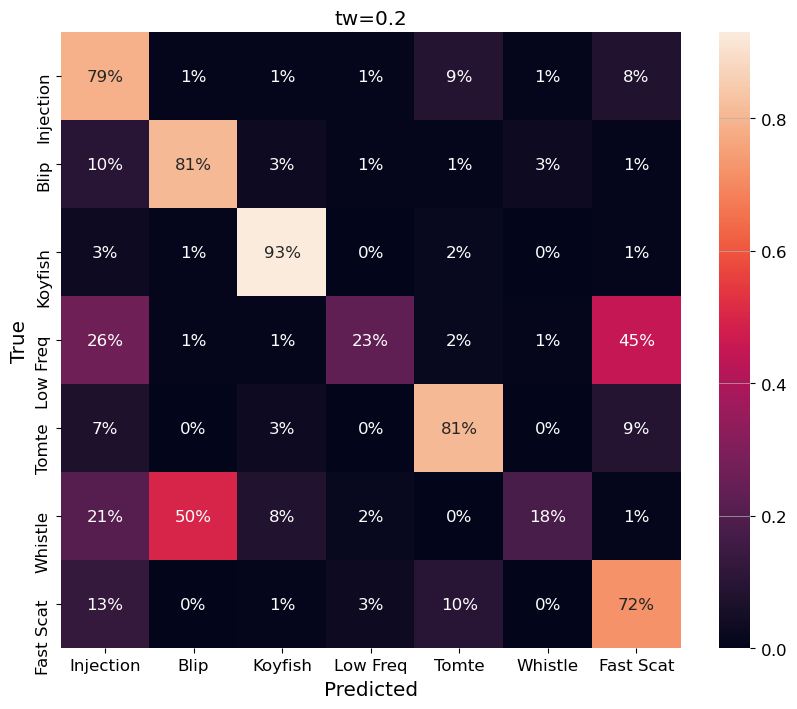

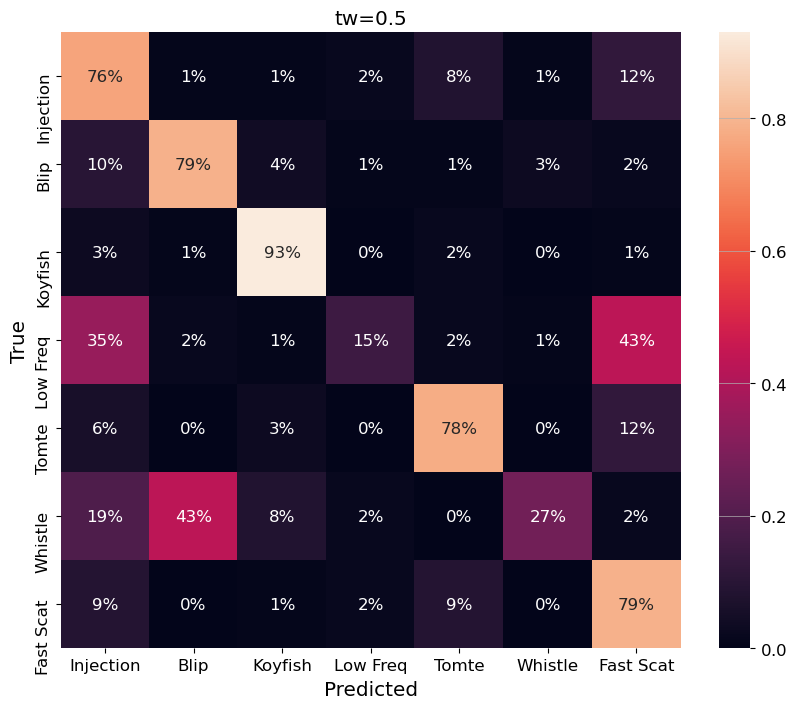

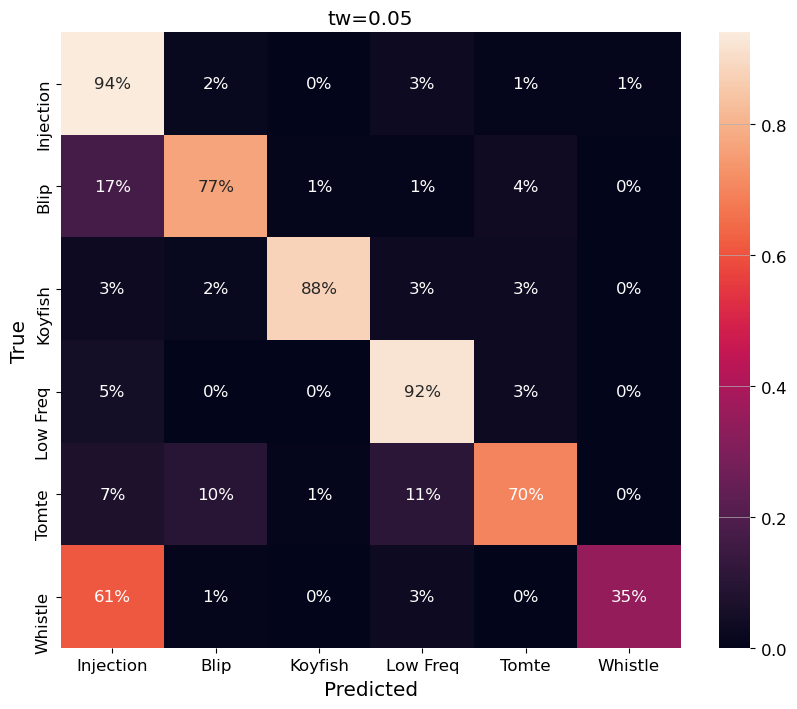

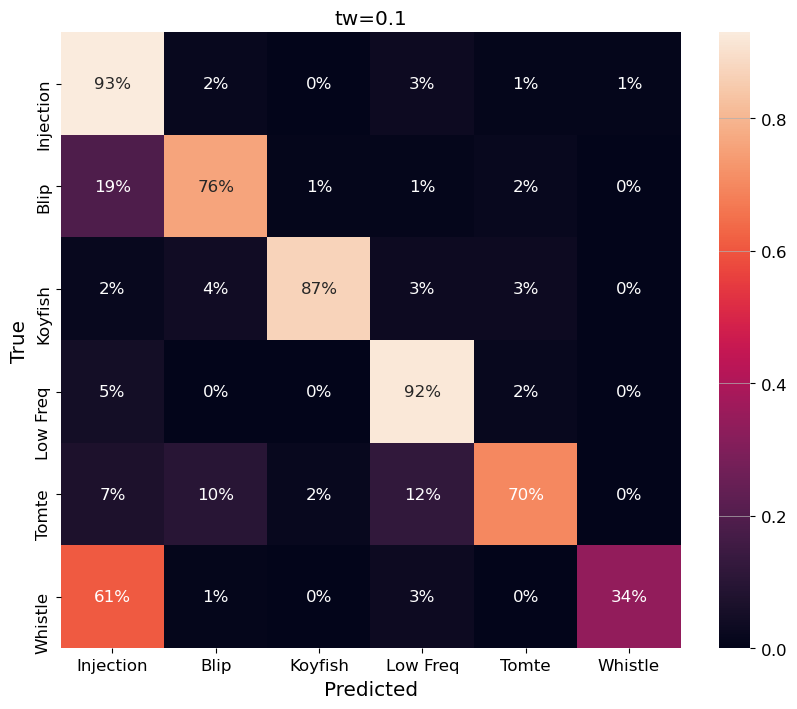

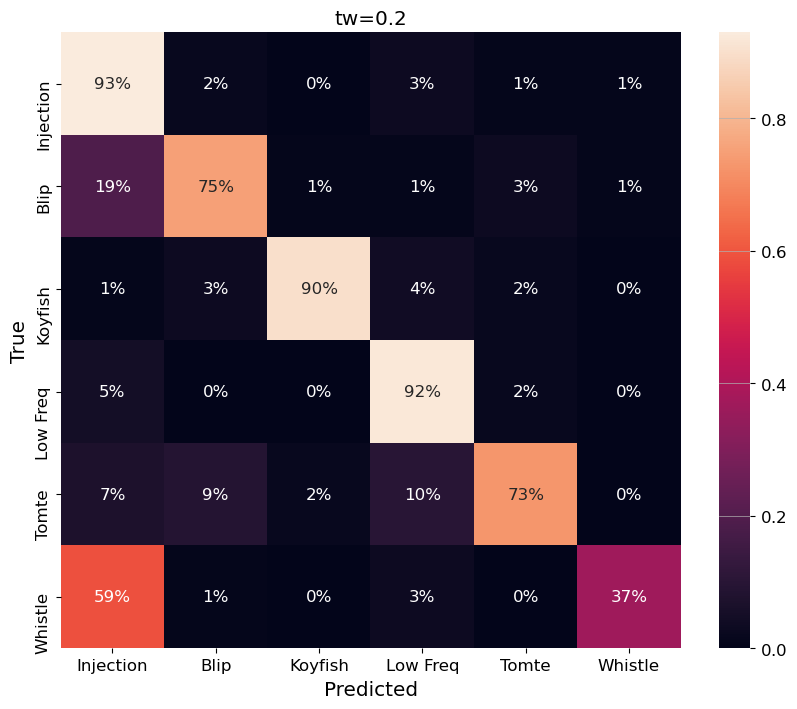

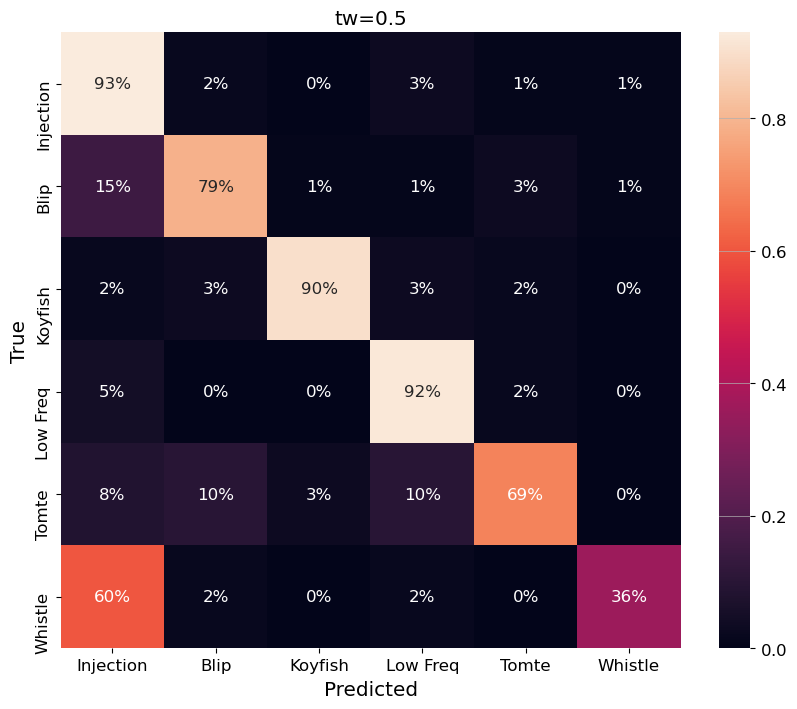

In [166]:
tw, ifo, run = 0.05, 'V1', 'O3b'
for ifo in ['H1', 'L1', 'V1']:
    for tw in [0.05, 0.1, 0.2, 0.5]:
        path = '../output_new/tw'+str(tw)+'/predictions/'
        file = 'pred_known_'+ifo+'_'+run+'.csv'
        tmp = pd.read_csv(path + file)
        tmp = tmp.loc[:, ~tmp.columns.str.match('Unnamed')]

        pred_labels = tmp.to_numpy()
        pred_labels = pred_labels[:, 7:]
        pred_labels = np.argmax(pred_labels, axis=1)
        true_labels = tmp['Class'].to_numpy()

        cfm = confusion_matrix(true_labels, pred_labels)
        cfm = np.round(cfm/np.sum(cfm, axis=1), 2)

        classes = ['Injection', 'Blip', 'Koyfish', 'Low Freq',
                   'Tomte', 'Whistle', 'Fast Scat']
        if ifo == 'V1':
            classes = classes[:-1]
        fig = plt.figure(figsize=(10, 8), dpi=100)
        sns.heatmap(cfm, annot=True, fmt=".0%")
        plt.xticks(np.arange(len(classes))+0.5, classes)
        plt.yticks(np.arange(len(classes))+0.5, classes)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.grid(False)
        plt.title('tw='+str(tw))
        plt.savefig('/data/gravwav/lopezm/Projects/GlitchBank/gifs/'+ifo+'/cfm_'+str(tw)+'_'+run+'.png')


In [44]:
tmp2 = tmp.loc[tmp['Class'] == 2]

Text(0, 0.5, 'Counts')

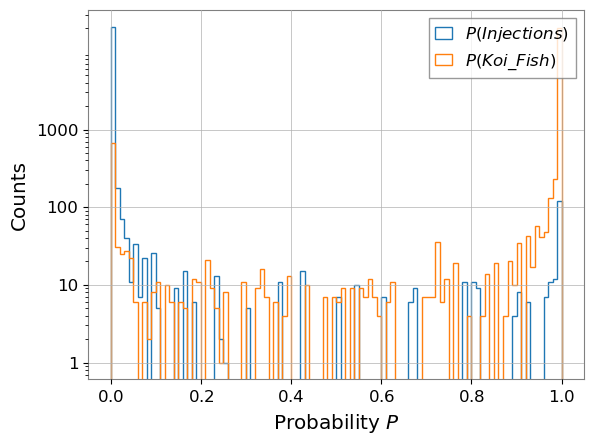

In [61]:
plt.hist(tmp2['Prob0'], density=False, bins=100,
         histtype='step', label=r'$P(Injections)$')
plt.hist(tmp2['Prob2'], density=False, bins=100,
         histtype='step', label=r'$P(Koi\_Fish)$')
plt.legend()
plt.yscale('log')
plt.yticks([1, 10, 100, 1000], [1, 10, 100, 1000])
plt.xlabel(r'Probability $P$')
plt.ylabel('Counts')

array([2., 4., 1., ..., 6., 6., 1.])

In [85]:
cfm = confusion_matrix(true_labels, pred_labels)
cfm = np.round(cfm/np.sum(cfm, axis=1), 2)

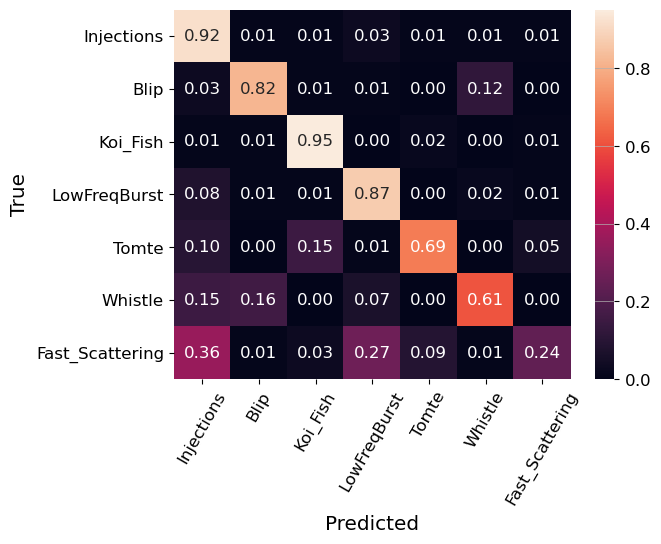

In [127]:
import os
from PIL import Image, ImageFont, ImageDraw

In [151]:
tw = 0.05
font = ImageFont.truetype("/data/gravwav/lopezm/Projects/GlitchBank/arial.ttf",25)

for ifo in ['H1', 'L1', 'V1']:
    for tw in [0.05, 0.1, 0.2, 0.5]:
        path = '/data/gravwav/lopezm/Projects/GlitchBank/computational-aspects-of-machine-learning-project-3/output_new/tw'+str(tw)+'/results/'
        for file in os.listdir(path):
            if ifo in file and file.endswith('png'):
                os.system('cp '+path+file+' /data/gravwav/lopezm/Projects/GlitchBank/gifs/'+ifo+'/cfm_'+str(tw)+'_O3a.png')
                i=Image.open('/data/gravwav/lopezm/Projects/GlitchBank/gifs/'+ifo+'/cfm_'+str(tw)+'_O3a.png')
                Im = ImageDraw.Draw(i)
                Im.text((475, 50), r"tw="+str(tw),fill=(0, 0, 0), font=font)
                i.save('/data/gravwav/lopezm/Projects/GlitchBank/gifs/'+ifo+'/cfm_'+str(tw)+'_O3a.png')

In [167]:
import glob
from PIL import Image
def make_gif(frame_folder, name):
    frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*O3b*.png")]
    frame_one = frames[0]
    frame_one.save(name, format="GIF", append_images=frames,
               save_all=True, duration=1000, loop=0)

for ifo in ['H1', 'L1', 'V1']:
    make_gif("/data/gravwav/lopezm/Projects/GlitchBank/gifs/"+ifo,
             '/data/gravwav/lopezm/Projects/GlitchBank/gifs/'+ifo+'/cfm_'+ifo+'_O3b.gif')

### Generate coincident CSVS

In [ ]:
for ifos in ['H1L1', 'L1V1', 'H1V1', 'H1L1V1']:
    for tw in [0.05, 0.1, 0.2, 0.5]:
        f = open("../../coinc_runs/run_"+ifos+"_"+str(tw)+".sh", "a")
        f.write("#!/usr/bin/bash"+ os.linesep +
        "source ~/.bashrc" + os.linesep +
        "conda activate /data/gravwav/lopezm/cmb_env/miniforge3/envs/ml_course"+ os.linesep +
        "python3 /data/gravwav/lopezm/Projects/GlitchBank/computational-aspects-of-machine-learning-project-3/src/unknown_coinc.py --tw="+str(tw)+" --ifos="+ifos)
        f.close()